In [1]:
import os
import json

import numpy as np
import pandas as pd

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import f1_score
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt

from ast import literal_eval
from tabulate import tabulate

import warnings
warnings.filterwarnings("ignore")

# Conjutos de Features

In [16]:
train_file_paths = {
    'Original': r'..\data\task1\features\train\features_raw.csv',
    'Z-Score': r'..\data\task1\features\train\features_z_score.csv',
    'Min-Max': r'..\data\task1\features\train\features_min_max_0_1.csv',
    'SN Min-Max': r'..\data\task1\features\train\features_signal_norm_-1_1_min_max_0_1.csv',
    'SN Z-Score': r'..\data\task1\features\train\features_signal_norm_-1_1_z_score.csv',
}

summary = {}

for name, path in train_file_paths.items():
    try:
        df = pd.read_csv(path)
        class_counts = df['Class'].value_counts().sort_index()
        summary[name] = class_counts
    except FileNotFoundError:
        print(f'Arquivo não encontrado: {path}')
    except Exception as e:
        print(f'Erro ao ler {name}: {e}')

summary_df = pd.DataFrame(summary).fillna(0).astype(int)
summary_df.index.name = 'Classe'
summary_df.loc['Total'] = summary_df.sum()
print(summary_df)


        Original  Z-Score  Min-Max  SN Min-Max  SN Z-Score
Classe                                                    
1              6        6        6           6           6
2             26       26       26          26          26
3             57       57       57          57          57
4             76       76       76          76          76
5            107      107      107         107         107
Total        272      272      272         272         272


In [6]:
df = pd.read_csv(r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\task1\features\train\features_thiago.csv')

id_vars = ['ID', 'Age', 'Sex', 'Class']
pivot_col = 'Audio Type'
value_cols = [col for col in df.columns if col not in id_vars + [pivot_col]]

df_pivot = df.set_index(id_vars + [pivot_col])[value_cols].unstack(level=pivot_col)
df_pivot.columns = ['{}_{}'.format(feature, audio_type) for feature, audio_type in df_pivot.columns]
df_pivot = df_pivot.reset_index()
df_pivot = df_pivot.dropna(axis=1, how='all')

print(f"Shape final: {df_pivot.shape}")

output_path = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\task1\features\train\features_thiago_pivot.csv'
df_pivot.to_csv(output_path, index=False)

Shape final: (272, 435)


# RANDOM FOREST

## Features João

### Divisão aleatória


Dataset: Original
--------------------------------------------------
Accuracy  - Train: 0.9355 | Test: 0.4182
F1-Score  - Train: 0.9244 | Test: 0.3653
--------------------------------------------------


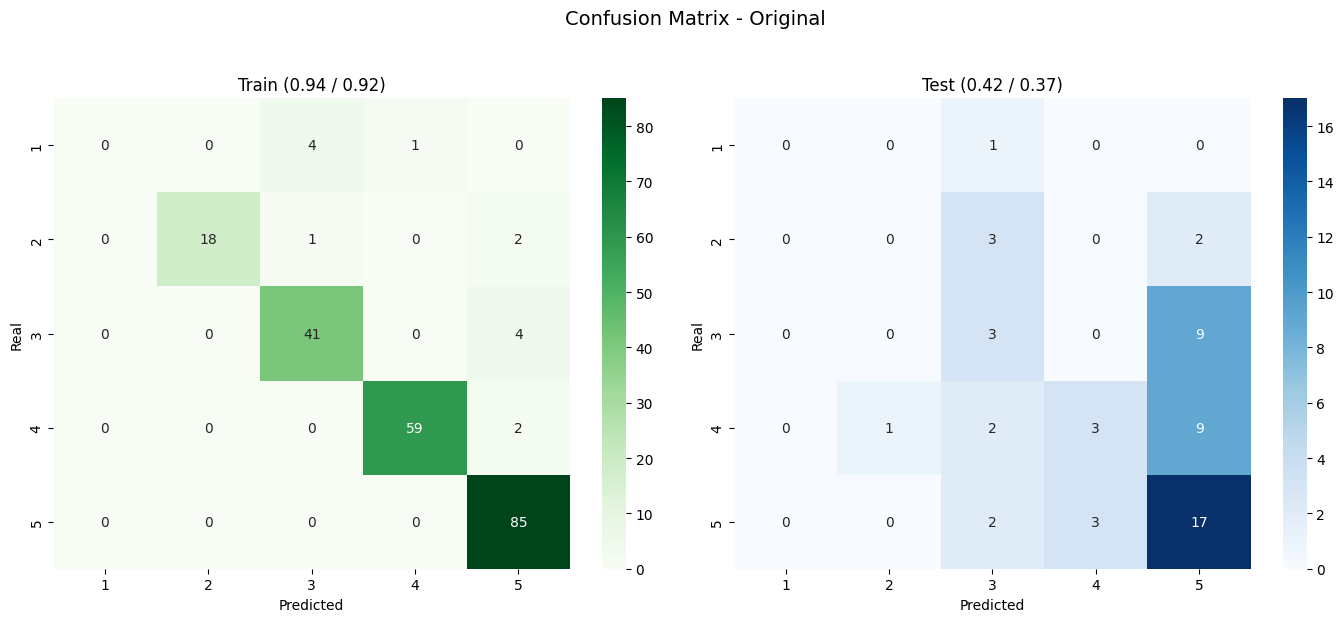


Dataset: Z-Score
--------------------------------------------------
Accuracy  - Train: 0.9355 | Test: 0.4182
F1-Score  - Train: 0.9244 | Test: 0.3653
--------------------------------------------------


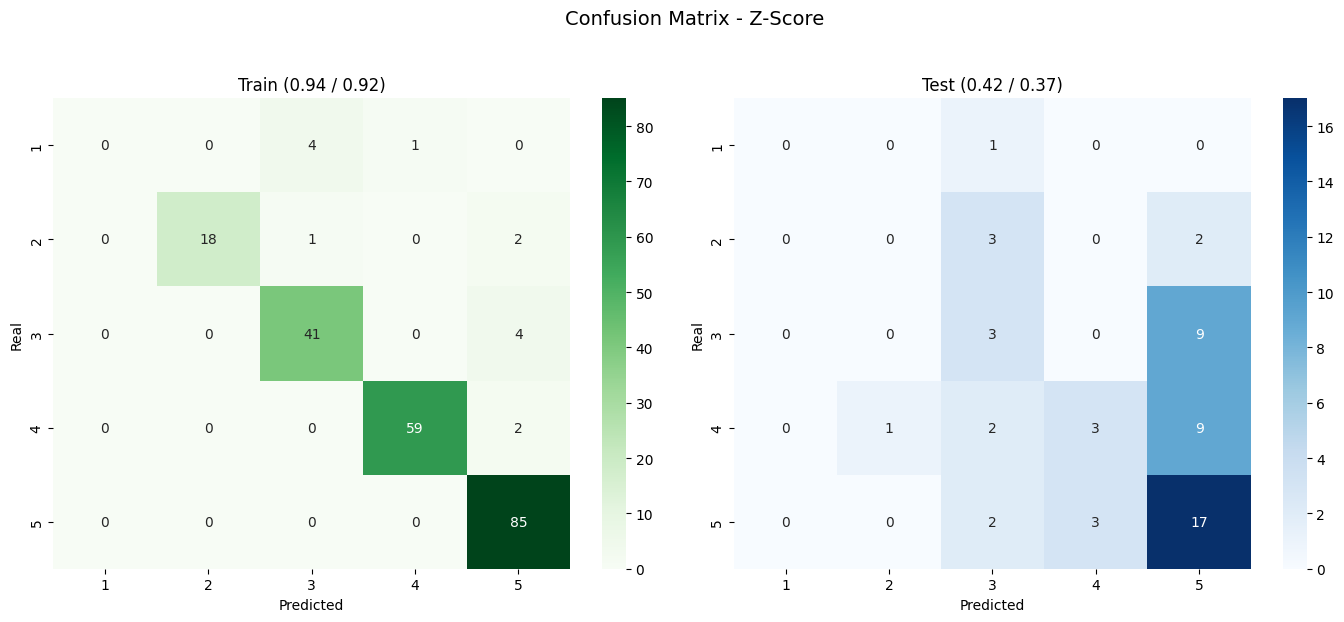


Dataset: Min-Max
--------------------------------------------------
Accuracy  - Train: 0.9355 | Test: 0.4182
F1-Score  - Train: 0.9244 | Test: 0.3653
--------------------------------------------------


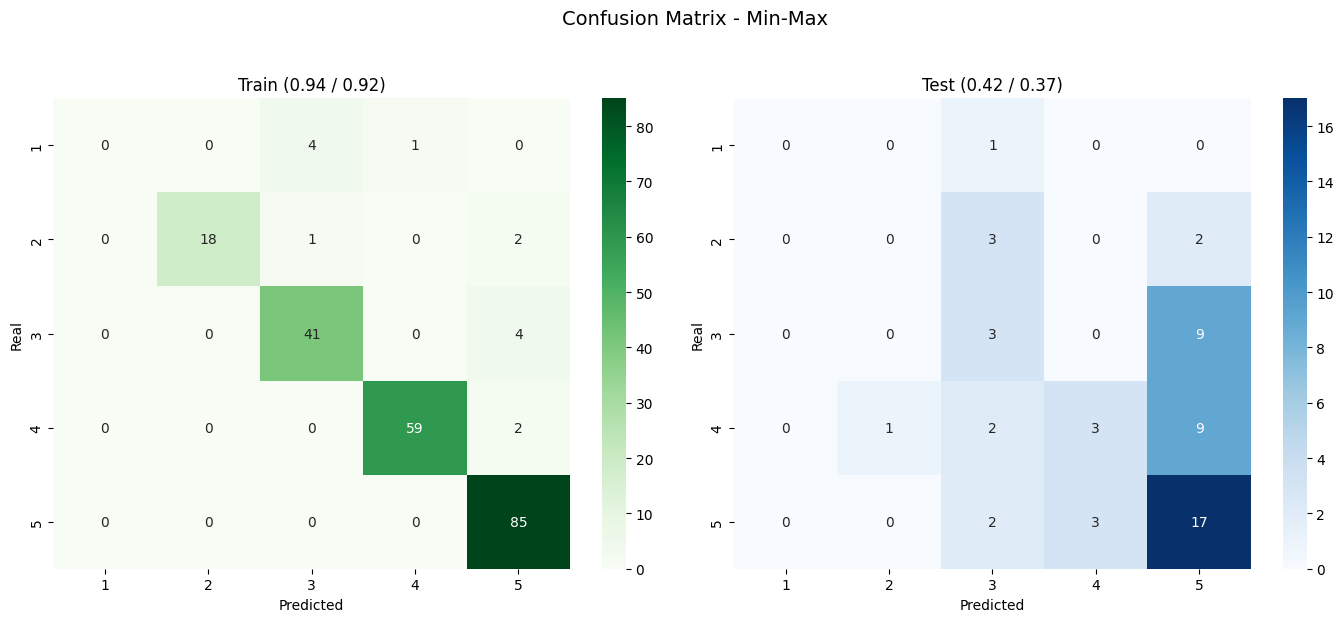


Dataset: SN Min-Max
--------------------------------------------------
Accuracy  - Train: 0.9355 | Test: 0.4182
F1-Score  - Train: 0.9244 | Test: 0.3653
--------------------------------------------------


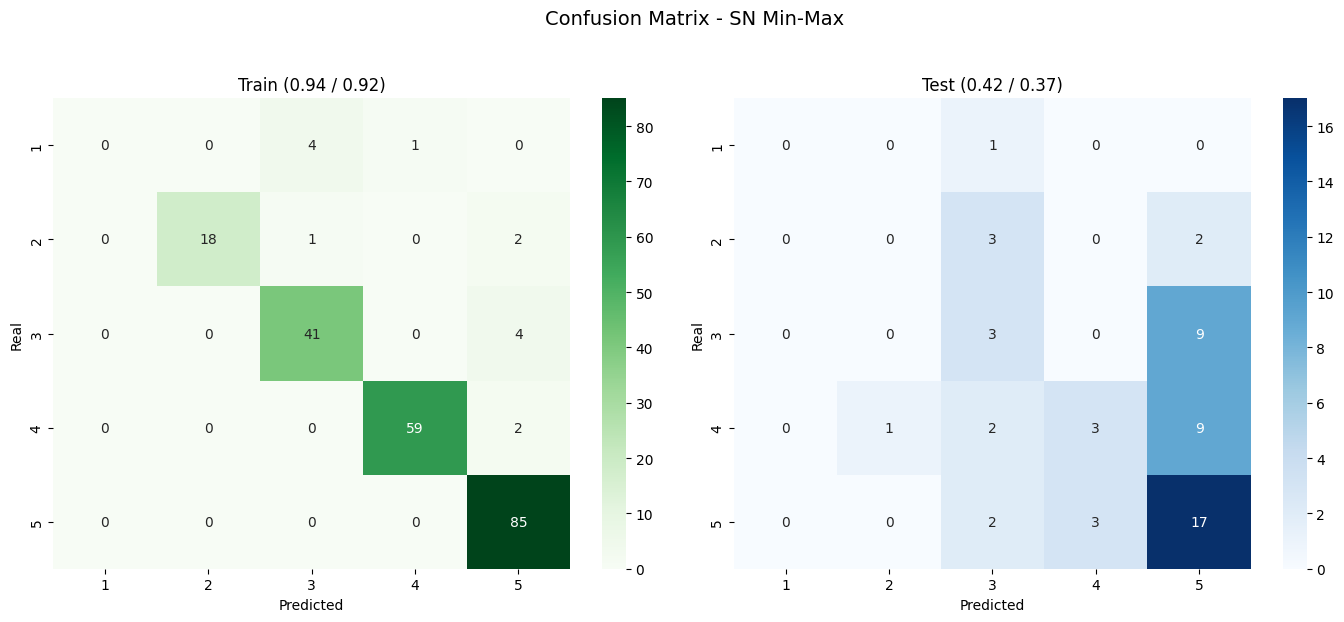


Dataset: SN Z-Score
--------------------------------------------------
Accuracy  - Train: 0.9355 | Test: 0.4182
F1-Score  - Train: 0.9244 | Test: 0.3653
--------------------------------------------------


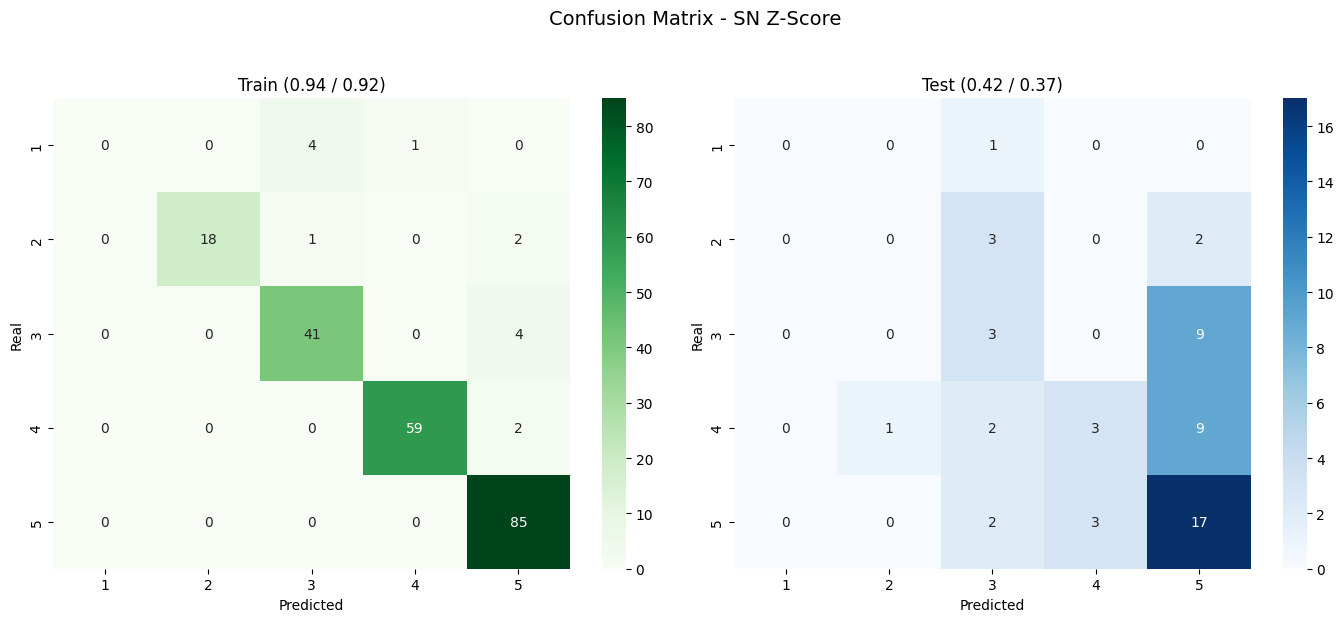

In [ ]:
train_file_paths = {
    'Original': r'..\data\task1\features\train\features_raw.csv',
    'Z-Score': r'..\data\task1\features\train\features_z_score.csv',
    'Min-Max': r'..\data\task1\features\train\features_min_max_0_1.csv',
    'SN Min-Max': r'..\data\task1\features\train\features_signal_norm_-1_1_min_max_0_1.csv',
    'SN Z-Score': r'..\data\task1\features\train\features_signal_norm_-1_1_z_score.csv',
}

rf_params = {
    'n_estimators': 200,
    'max_depth': 15,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}

TEST_SIZE_PERCENTAGE = 0.2
META_COLUMNS = ['ID', 'Class']
results = []

for name, train_path in train_file_paths.items():
    print(f'\nDataset: {name}')
    
    try:
        df_train_full = pd.read_csv(train_path)
    except FileNotFoundError as e:
        print(f'Erro: {e}')
        continue

    if 'Sex' in df_train_full.columns:
        df_train_full['Sex'] = df_train_full['Sex'].map({'M': 0, 'F': 1})
    
    X_full_orig = df_train_full.drop(columns=META_COLUMNS)
    y_full = df_train_full['Class']

    X_train_orig, X_test_orig, y_train, y_test = train_test_split(
        X_full_orig, y_full, test_size=TEST_SIZE_PERCENTAGE, stratify=y_full, random_state=42
    )
    
    if 'Original' in name:
        scaler = StandardScaler()
        X_train_processed = scaler.fit_transform(X_train_orig)
        X_test_processed = scaler.transform(X_test_orig)
    else:
        X_train_processed = X_train_orig.values
        X_test_processed = X_test_orig.values

    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_train_processed, y_train)

    y_train_pred = rf.predict(X_train_processed)
    y_test_pred = rf.predict(X_test_processed)

    acc_train = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    acc_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    print('-' * 50)
    print(f'Accuracy  - Train: {acc_train:.4f} | Test: {acc_test:.4f}')
    print(f'F1-Score  - Train: {f1_train:.4f} | Test: {f1_test:.4f}')
    print('-' * 50)
    
    results.append({
        'Dataset': name,
        'Accuracy': acc_test,
        'F1-Score': f1_test
    })

    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    labels = sorted(y_full.unique())

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title(f'Train ({acc_train:.2f} / {f1_train:.2f})')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Real')

    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title(f'Test ({acc_test:.2f} / {f1_test:.2f})')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Real')

    plt.suptitle(f'Confusion Matrices - {name}', fontsize=14, y=1.03)
    plt.tight_layout()
    plt.show()

    # importances = pd.Series(rf.feature_importances_, index=X_train_orig.columns)
    # plt.figure(figsize=(8, 6))
    # importances.nlargest(20).sort_values().plot(kind='barh')
    # plt.title(f'Top 20 Features Importantes - {name}')
    # plt.show()

### IDs do Baseline


Dataset: Original
--------------------------------------------------
Accuracy - Train: 0.9452 | Test: 0.5094
F1-Score - Train: 0.9360 | Test: 0.4598
--------------------------------------------------


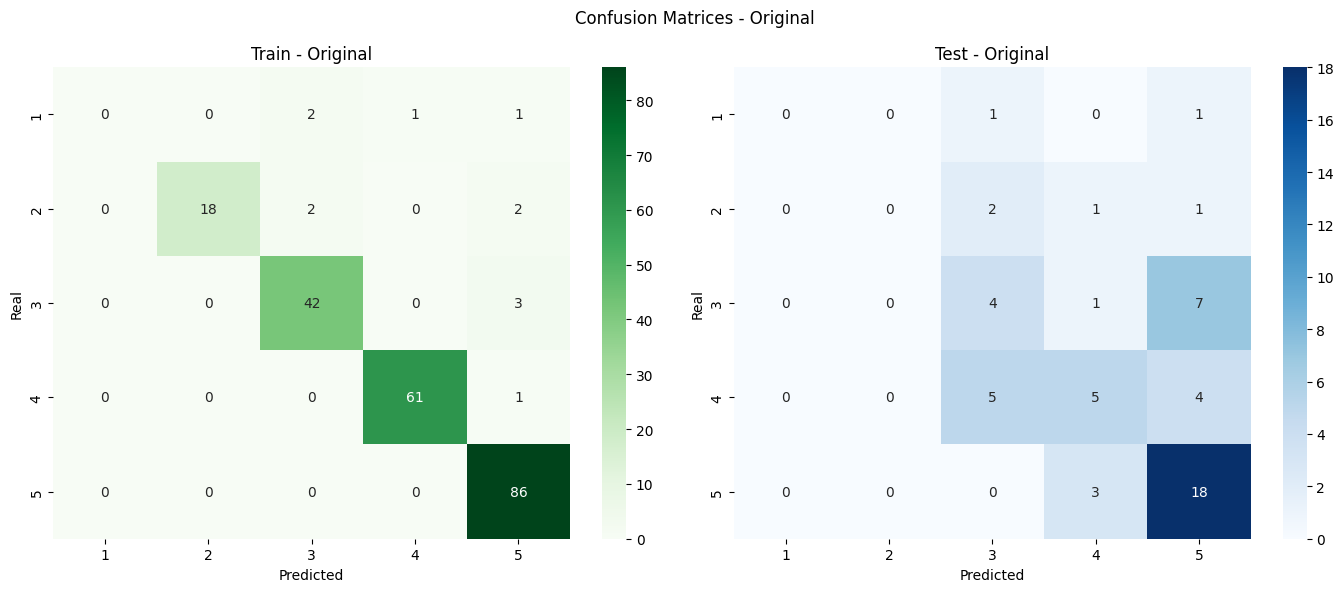


Dataset: Z-Score
--------------------------------------------------
Accuracy - Train: 0.9452 | Test: 0.5283
F1-Score - Train: 0.9360 | Test: 0.4933
--------------------------------------------------


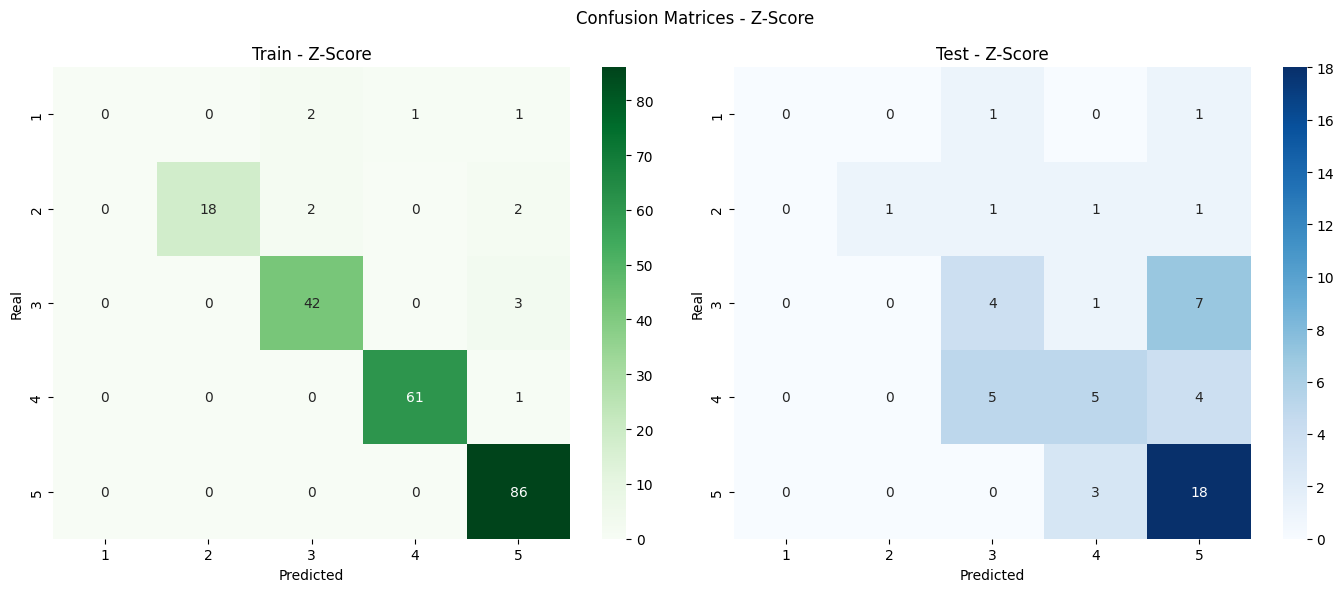


Dataset: Min-Max
--------------------------------------------------
Accuracy - Train: 0.9452 | Test: 0.5283
F1-Score - Train: 0.9360 | Test: 0.4933
--------------------------------------------------


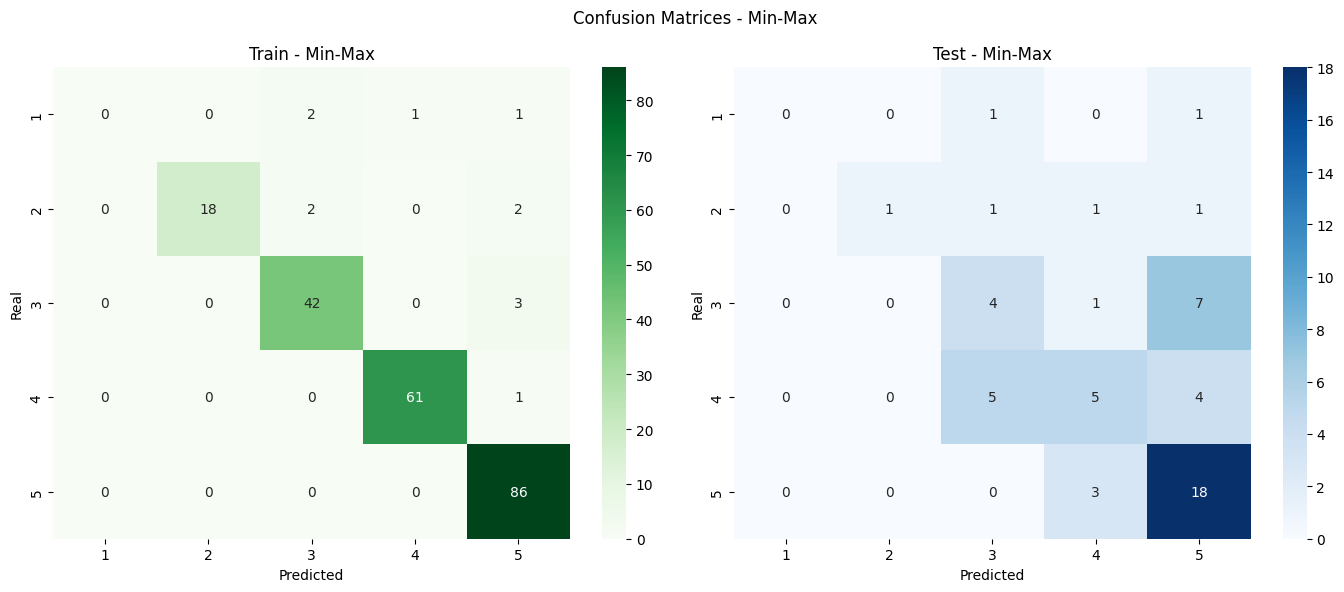


Dataset: SN Min-Max
--------------------------------------------------
Accuracy - Train: 0.9452 | Test: 0.5283
F1-Score - Train: 0.9360 | Test: 0.4933
--------------------------------------------------


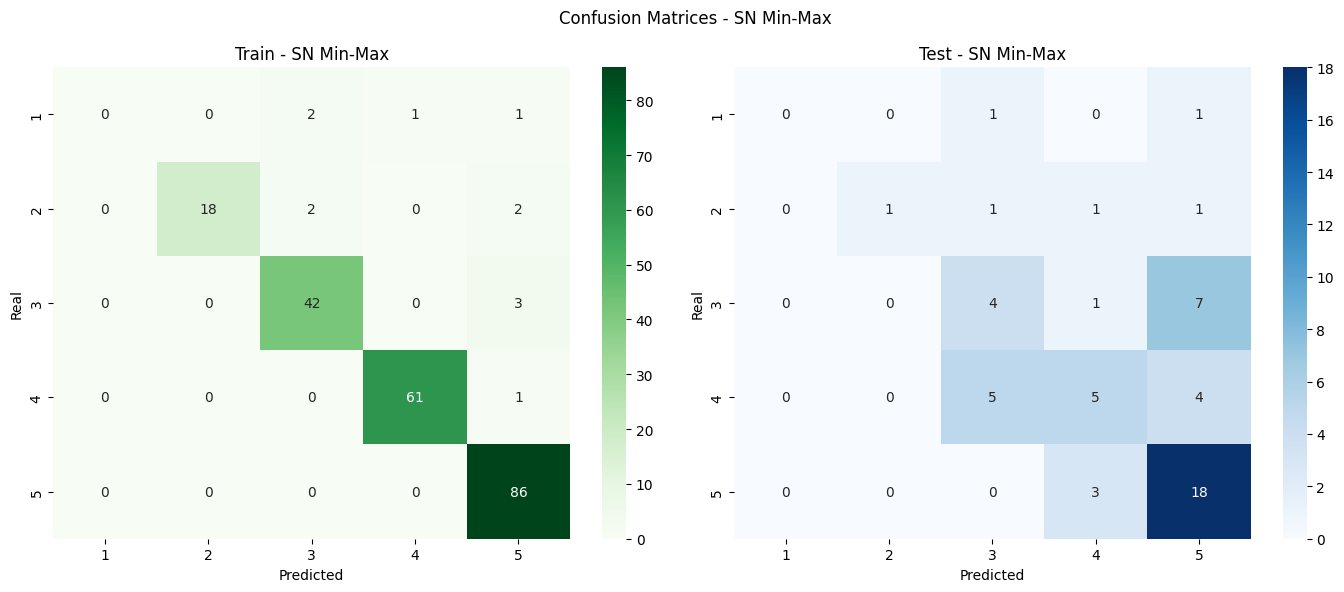


Dataset: SN Z-Score
--------------------------------------------------
Accuracy - Train: 0.9452 | Test: 0.5283
F1-Score - Train: 0.9360 | Test: 0.4933
--------------------------------------------------


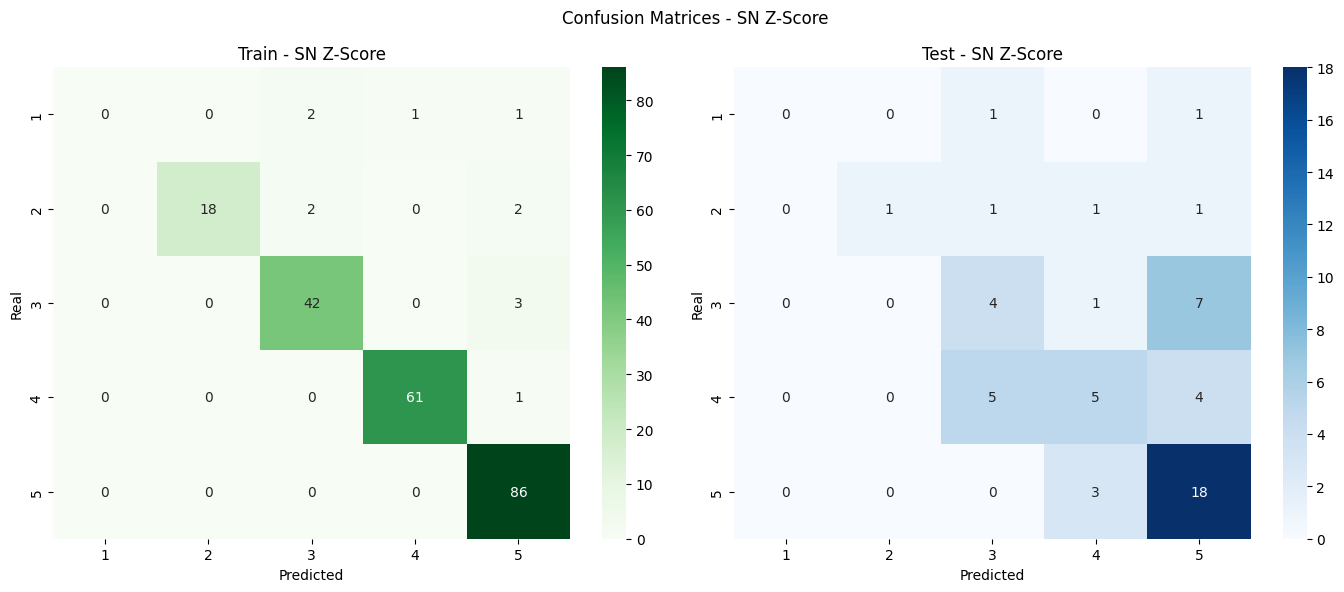

In [32]:
test_ids = [
    "ID007","ID012","ID021","ID029","ID037","ID046","ID051","ID053","ID054","ID056",
    "ID063","ID075","ID083","ID090","ID099","ID101","ID105","ID110","ID116","ID122",
    "ID129","ID136","ID138","ID140","ID158","ID160","ID164","ID171","ID176","ID179",
    "ID202","ID209","ID227","ID229","ID233","ID245","ID252","ID253","ID260","ID261",
    "ID263","ID264","ID269","ID270","ID274","ID278","ID284","ID286","ID290","ID302",
    "ID306","ID323","ID329"
]

train_file_paths = {
    'Original': r'..\data\task1\features\train\features_raw.csv',
    'Z-Score': r'..\data\task1\features\train\features_z_score.csv',
    'Min-Max': r'..\data\task1\features\train\features_min_max_0_1.csv',
    'SN Min-Max': r'..\data\task1\features\train\features_signal_norm_-1_1_min_max_0_1.csv',
    'SN Z-Score': r'..\data\task1\features\train\features_signal_norm_-1_1_z_score.csv',
}

rf_params = {
    'n_estimators': 200,
    'max_depth': 15,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}

META_COLUMNS = ['ID', 'Class']

results = []

for name, train_path in train_file_paths.items():
    print(f'\nDataset: {name}')
    
    try:
        df_full = pd.read_csv(train_path)
    except FileNotFoundError as e:
        print(f'Erro: {e}')
        continue

    df_full['Sex'] = df_full['Sex'].map({'M': 0, 'F': 1})
    
    df_test_val = df_full[df_full['ID'].isin(test_ids)].copy()
    df_train = df_full[~df_full['ID'].isin(test_ids)].copy()

    X_train_orig = df_train.drop(columns=META_COLUMNS)
    y_train = df_train['Class']
    X_test_orig = df_test_val.drop(columns=META_COLUMNS)
    y_test = df_test_val['Class']

    if 'Original' in name:
        scaler = StandardScaler()
        X_train_processed = scaler.fit_transform(X_train_orig)
        X_test_processed = scaler.transform(X_test_orig)
    else:
        X_train_processed = X_train_orig.values
        X_test_processed = X_test_orig.values

    rf = RandomForestClassifier(**rf_params)
    rf.fit(X_train_processed, y_train)

    y_train_pred = rf.predict(X_train_processed)
    y_test_pred = rf.predict(X_test_processed)
    
    acc_train = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    acc_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    print('-' * 50)
    print(f'Accuracy - Train: {acc_train:.4f} | Test: {acc_test:.4f}')
    print(f'F1-Score - Train: {f1_train:.4f} | Test: {f1_test:.4f}')
    print('-' * 50)
    
    results.append({
        'Dataset': name,
        'Accuracy Train': acc_train,
        'F1-Score Train': f1_train,
        'Accuracy Test': acc_test,
        'F1-Score Test': f1_test
    })

    labels = sorted(df_full['Class'].unique())
    cm_train = confusion_matrix(y_train, y_train_pred, labels=labels)
    cm_test = confusion_matrix(y_test, y_test_pred, labels=labels)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title(f'Train - {name}')
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Real')

    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title(f'Test - {name}')
    axes[1].set_xlabel('Predicted')
    axes[1].set_ylabel('Real')

    plt.suptitle(f'Confusion Matrices - {name}')
    plt.tight_layout()
    plt.show()

## Features do Thiago

### Divisão aleatória


Dataset: Thiago Pivot
--------------------------------------------------
Accuracy  - Train: 0.9401 | Test: 0.5455
F1-Score  - Train: 0.9291 | Test: 0.4981
--------------------------------------------------


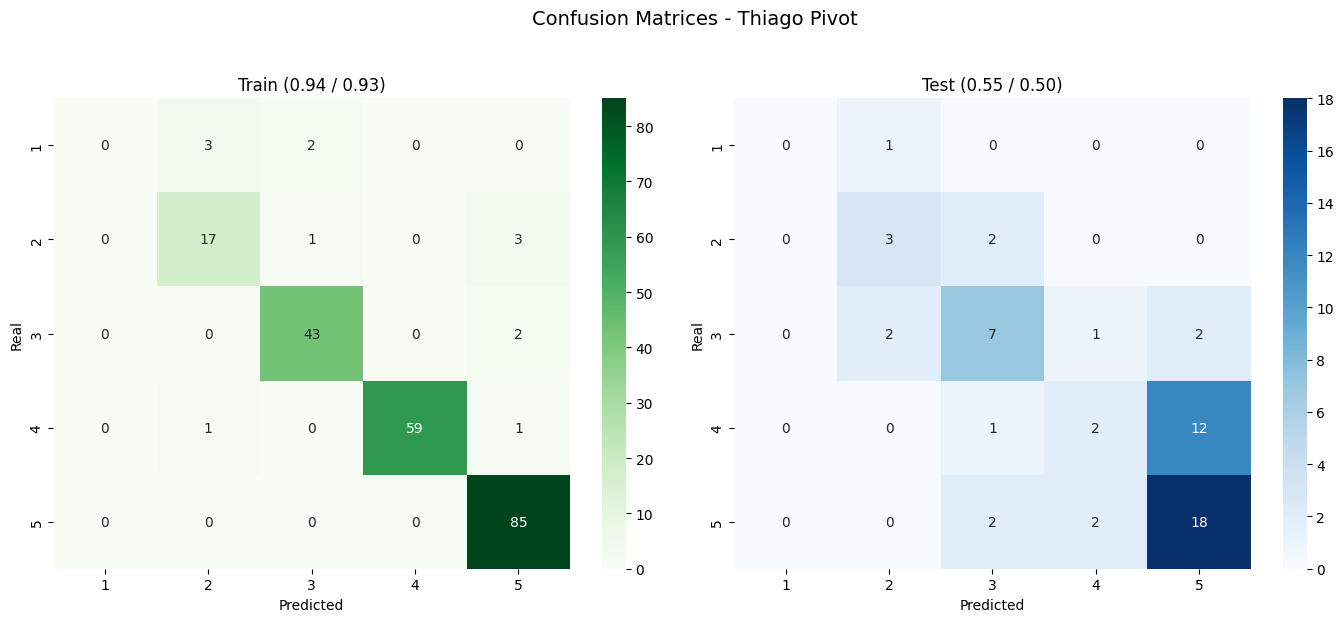

In [31]:
train_file_path = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\task1\features\train\features_thiago_pivot.csv'

rf_params = {
    'n_estimators': 200,
    'max_depth': 15,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}

TEST_SIZE_PERCENTAGE = 0.2
META_COLUMNS = ['ID', 'Class']

df_train_full = pd.read_csv(train_file_path)

if 'Sex' in df_train_full.columns:
    df_train_full['Sex'] = df_train_full['Sex'].map({'M': 0, 'F': 1})

df_train_full = df_train_full.dropna(axis=1, how='all')

def try_parse_array(x):
    try:
        val = literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
        if isinstance(val, (list, tuple, np.ndarray)):
            return np.mean(val)
        return val
    except Exception:
        return x

for col in df_train_full.columns:
    if df_train_full[col].astype(str).str.startswith('[').any():
        df_train_full[col] = df_train_full[col].apply(try_parse_array)

X_full_orig = df_train_full.drop(columns=META_COLUMNS)
y_full = df_train_full['Class']
X_full_orig = X_full_orig.select_dtypes(include=[np.number])

X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    X_full_orig, y_full, test_size=TEST_SIZE_PERCENTAGE, stratify=y_full, random_state=42
)

scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train_orig)
X_test_processed = scaler.transform(X_test_orig)

rf = RandomForestClassifier(**rf_params)
rf.fit(X_train_processed, y_train)

y_train_pred = rf.predict(X_train_processed)
y_test_pred = rf.predict(X_test_processed)

acc_train = accuracy_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred, average='weighted')
acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print(f'\nDataset: Thiago Pivot')
print('-' * 50)
print(f'Accuracy  - Train: {acc_train:.4f} | Test: {acc_test:.4f}')
print(f'F1-Score  - Train: {f1_train:.4f} | Test: {f1_test:.4f}')
print('-' * 50)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
labels = sorted(y_full.unique())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title(f'Train ({acc_train:.2f} / {f1_train:.2f})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Real')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title(f'Test ({acc_test:.2f} / {f1_test:.2f})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Real')

plt.suptitle(f'Confusion Matrices - Thiago Pivot', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

### IDs do Baseline

Train: 219 | Test: 53

Dataset: Thiago Pivot
--------------------------------------------------
Accuracy  - Train: 0.9361 | Test: 0.5660
F1-Score  - Train: 0.9274 | Test: 0.4977
--------------------------------------------------


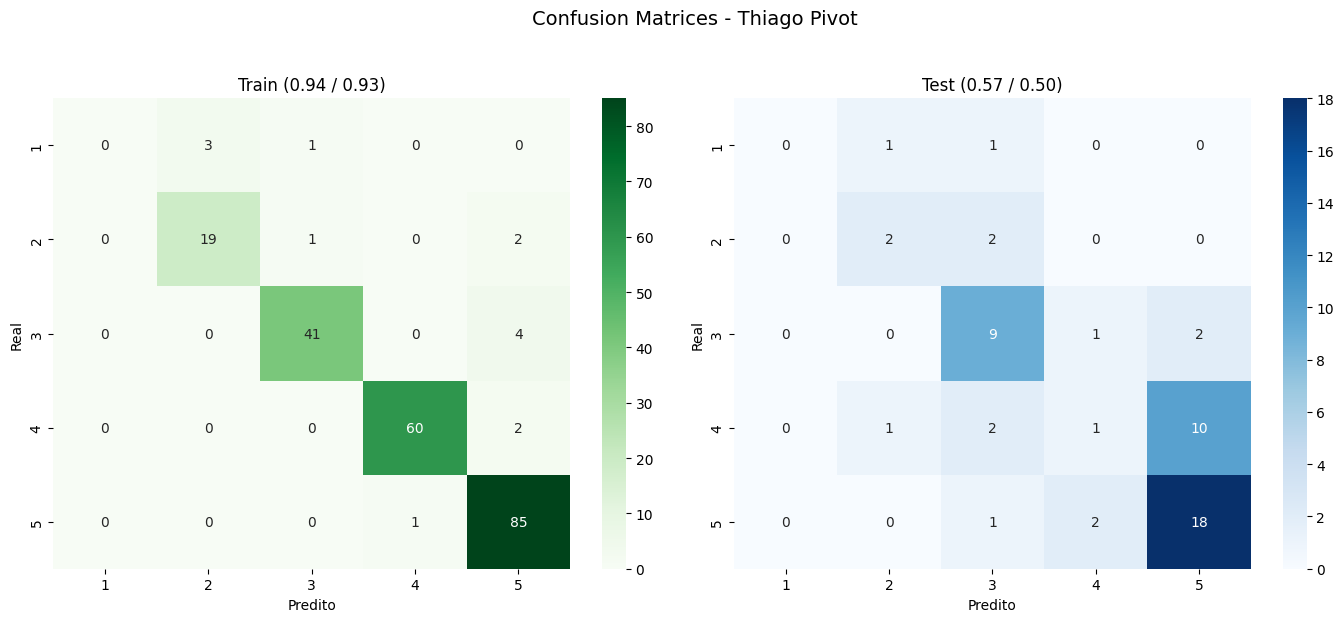

In [14]:
# train_file_path = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\task1\features\train\features_thiago_pivot.csv'
train_file_path = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\task1\features\train\features_filtered.csv'

test_ids = [
    "ID007","ID012","ID021","ID029","ID037","ID046","ID051","ID053","ID054","ID056",
    "ID063","ID075","ID083","ID090","ID099","ID101","ID105","ID110","ID116","ID122",
    "ID129","ID136","ID138","ID140","ID158","ID160","ID164","ID171","ID176","ID179",
    "ID202","ID209","ID227","ID229","ID233","ID245","ID252","ID253","ID260","ID261",
    "ID263","ID264","ID269","ID270","ID274","ID278","ID284","ID286","ID290","ID302",
    "ID306","ID323","ID329"
]

rf_params = {
    'n_estimators': 200,
    'max_depth': 15,
    'min_samples_leaf': 5,
    'max_features': 'sqrt',
    'random_state': 42,
    'n_jobs': -1
}

META_COLUMNS = ['ID', 'Class']

df = pd.read_csv(train_file_path)

if 'Sex' in df.columns:
    df['Sex'] = df['Sex'].map({'M': 0, 'F': 1})

df = df.dropna(axis=1, how='all')

def try_parse_array(x):
    try:
        val = literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
        if isinstance(val, (list, tuple, np.ndarray)):
            return np.mean(val)
        return val
    except Exception:
        return x

for col in df.columns:
    if df[col].astype(str).str.startswith('[').any():
        df[col] = df[col].apply(try_parse_array)

df['ID'] = df['ID'].astype(str)

df_test = df[df['ID'].isin(test_ids)].copy()
df_train = df[~df['ID'].isin(test_ids)].copy()
print(f"Train: {len(df_train)} | Test: {len(df_test)}")

X_train_orig = df_train.drop(columns=META_COLUMNS)
y_train = df_train['Class']

X_test_orig = df_test.drop(columns=META_COLUMNS)
y_test = df_test['Class']

X_train_orig = X_train_orig.select_dtypes(include=[np.number])
X_test_orig = X_test_orig[X_train_orig.columns]

scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train_orig)
X_test_processed = scaler.transform(X_test_orig)

rf = RandomForestClassifier(**rf_params)
rf.fit(X_train_processed, y_train)

y_train_pred = rf.predict(X_train_processed)
y_test_pred = rf.predict(X_test_processed)

acc_train = accuracy_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred, average='weighted')
acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print(f'\nDataset: Thiago Pivot')
print('-' * 50)
print(f'Accuracy  - Train: {acc_train:.4f} | Test: {acc_test:.4f}')
print(f'F1-Score  - Train: {f1_train:.4f} | Test: {f1_test:.4f}')
print('-' * 50)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
labels = sorted(df['Class'].unique())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title(f'Train ({acc_train:.2f} / {f1_train:.2f})')
axes[0].set_xlabel('Predito')
axes[0].set_ylabel('Real')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title(f'Test ({acc_test:.2f} / {f1_test:.2f})')
axes[1].set_xlabel('Predito')
axes[1].set_ylabel('Real')

plt.suptitle(f'Confusion Matrices - Thiago Pivot', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

## Considerações

O modelo sempre aprende muito bem o conjunto de treino, mas temos um overfitting no conjunto de teste, ou seja, o modelo está capturando padrões muito específicos do treino que não generalizam.

Ajustes:

- Controle de complexidade
- Busca por melhores hiperparâmetros
- Remoção colunas irrelevantes

Observação: O resultado provavelmente vai piorar piorar após tuning

Train: 219 | Test: 53

RandomizedSearchCV...

Best hyperparameters found:
  n_estimators: 200
  min_samples_leaf: 6
  max_features: sqrt
  max_depth: 12
  class_weight: balanced

Dataset: Thiago Pivot
--------------------------------------------------
Accuracy  - Train: 0.9543 | Test: 0.4528
F1-Score  - Train: 0.9559 | Test: 0.4708
--------------------------------------------------


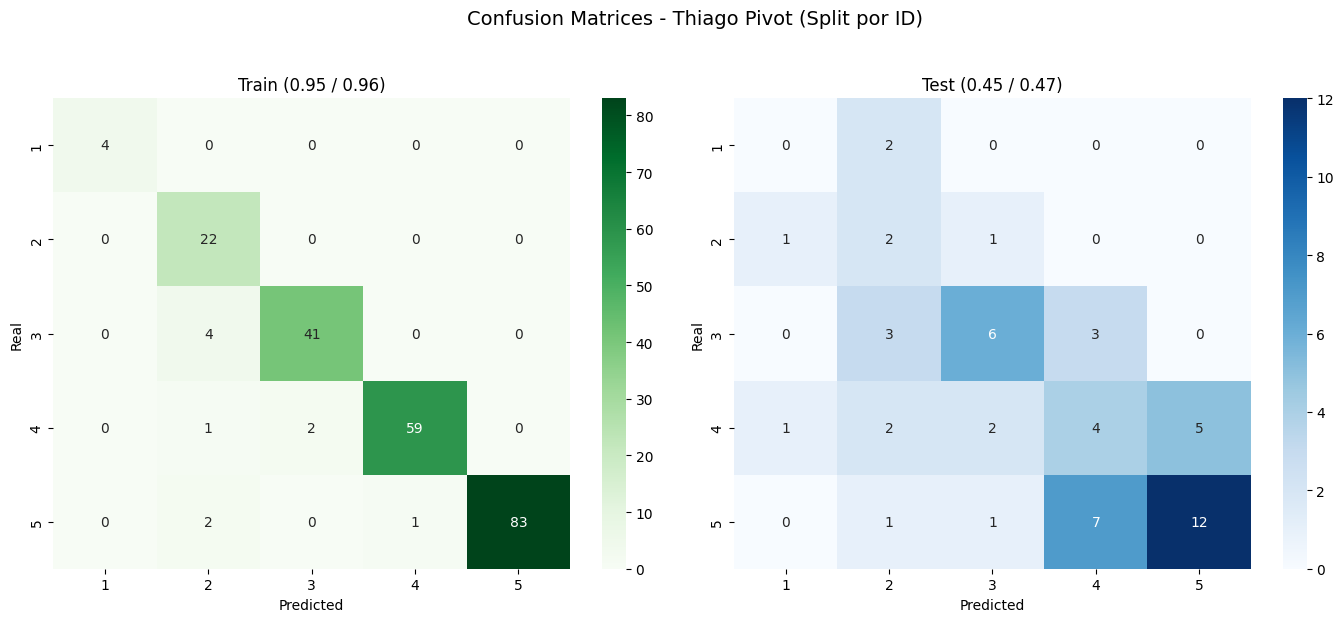


34 features with importance < 0.001

Refit:
--------------------------------------------------
Accuracy  - Train: 0.9543 | Test: 0.4906
F1-Score  - Train: 0.9553 | Test: 0.4916
--------------------------------------------------


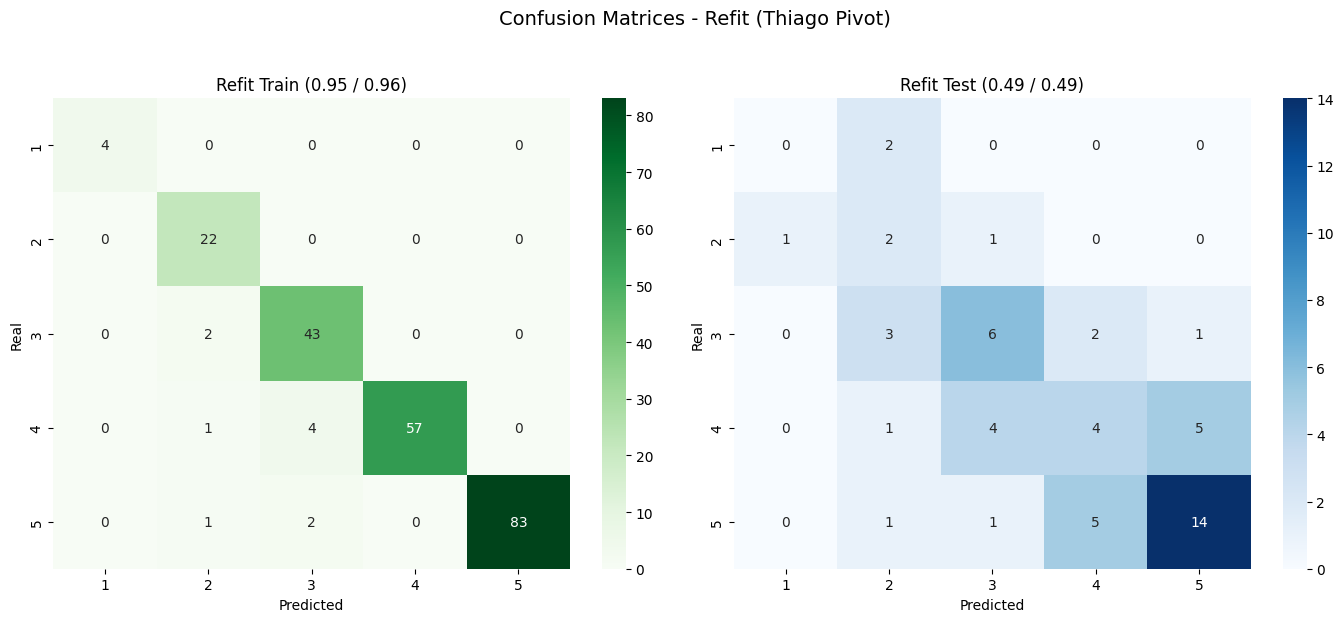

In [35]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.preprocessing import StandardScaler
test_ids = [
    "ID007","ID012","ID021","ID029","ID037","ID046","ID051","ID053","ID054","ID056",
    "ID063","ID075","ID083","ID090","ID099","ID101","ID105","ID110","ID116","ID122",
    "ID129","ID136","ID138","ID140","ID158","ID160","ID164","ID171","ID176","ID179",
    "ID202","ID209","ID227","ID229","ID233","ID245","ID252","ID253","ID260","ID261",
    "ID263","ID264","ID269","ID270","ID274","ID278","ID284","ID286","ID290","ID302",
    "ID306","ID323","ID329"
]

train_file_path = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\task1\features\train\features_thiago_pivot.csv'
META_COLUMNS = ['ID', 'Class']

df = pd.read_csv(train_file_path)

if 'Sex' in df.columns:
    df['Sex'] = df['Sex'].map({'M': 0, 'F': 1})

df = df.dropna(axis=1, how='all')

def try_parse_array(x):
    try:
        val = literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
        if isinstance(val, (list, tuple, np.ndarray)):
            return np.mean(val)
        return val
    except Exception:
        return x

for col in df.columns:
    if df[col].astype(str).str.startswith('[').any():
        # print(f'Convertendo coluna com arrays: {col}')
        df[col] = df[col].apply(try_parse_array)

df['ID'] = df['ID'].astype(str)

df_test = df[df['ID'].isin(test_ids)].copy()
df_train = df[~df['ID'].isin(test_ids)].copy()

print(f"Train: {len(df_train)} | Test: {len(df_test)}")

X_train_orig = df_train.drop(columns=META_COLUMNS)
y_train = df_train['Class']
X_test_orig = df_test.drop(columns=META_COLUMNS)
y_test = df_test['Class']

X_train_orig = X_train_orig.select_dtypes(include=[np.number])
X_test_orig = X_test_orig[X_train_orig.columns]

vt = VarianceThreshold(threshold=0.01)
X_train_vt = vt.fit_transform(X_train_orig)
X_test_vt = vt.transform(X_test_orig)
selected_features = X_train_orig.columns[vt.get_support()]
X_train_vt = pd.DataFrame(X_train_vt, columns=selected_features)
X_test_vt = pd.DataFrame(X_test_vt, columns=selected_features)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train_vt)
X_test = scaler.transform(X_test_vt)

param_dist = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 8, 10, 12, 15],
    'min_samples_leaf': [2, 4, 6, 8, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': [None, 'balanced']
}

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
print("\nRandomizedSearchCV...")

search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=15,
    scoring='f1_weighted',
    cv=5,
    random_state=42,
    n_jobs=-1
)
search.fit(X_train, y_train)

best_params = search.best_params_
print("\nBest hyperparameters found:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

rf_best = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
rf_best.fit(X_train, y_train)

y_train_pred = rf_best.predict(X_train)
y_test_pred = rf_best.predict(X_test)

acc_train = accuracy_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred, average='weighted')
acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print(f'\nDataset: Thiago Pivot')
print('-' * 50)
print(f'Accuracy  - Train: {acc_train:.4f} | Test: {acc_test:.4f}')
print(f'F1-Score  - Train: {f1_train:.4f} | Test: {f1_test:.4f}')
print('-' * 50)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
labels = sorted(y_test.unique())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title(f'Train ({acc_train:.2f} / {f1_train:.2f})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Real')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title(f'Test ({acc_test:.2f} / {f1_test:.2f})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Real')

plt.suptitle(f'Confusion Matrices - Thiago Pivot (Split por ID)', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

# importances = pd.Series(rf_best.feature_importances_, index=selected_features)
# top_features = importances.nlargest(20)
# plt.figure(figsize=(8, 6))
# top_features.sort_values().plot(kind='barh')
# plt.title('Top 20 Features Importantes')
# plt.show()

low_imp = importances[importances < 0.001]
print(f"\n{len(low_imp)} features with importance < 0.001")

low_imp_features = low_imp.index.tolist()
X_train_reduced = X_train_vt.drop(columns=low_imp_features, errors='ignore')
X_test_reduced = X_test_vt.drop(columns=low_imp_features, errors='ignore')

scaler = StandardScaler()
X_train_reduced = scaler.fit_transform(X_train_reduced)
X_test_reduced = scaler.transform(X_test_reduced)

rf_refit = RandomForestClassifier(**best_params, random_state=42, n_jobs=-1)
rf_refit.fit(X_train_reduced, y_train)

y_train_refit = rf_refit.predict(X_train_reduced)
y_test_refit = rf_refit.predict(X_test_reduced)

acc_train_refit = accuracy_score(y_train, y_train_refit)
f1_train_refit = f1_score(y_train, y_train_refit, average='weighted')
acc_test_refit = accuracy_score(y_test, y_test_refit)
f1_test_refit = f1_score(y_test, y_test_refit, average='weighted')

print('\nRefit:')
print('-' * 50)
print(f'Accuracy  - Train: {acc_train_refit:.4f} | Test: {acc_test_refit:.4f}')
print(f'F1-Score  - Train: {f1_train_refit:.4f} | Test: {f1_test_refit:.4f}')
print('-' * 50)

cm_train_refit = confusion_matrix(y_train, y_train_refit)
cm_test_refit = confusion_matrix(y_test, y_test_refit)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
sns.heatmap(cm_train_refit, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title(f'Refit Train ({acc_train_refit:.2f} / {f1_train_refit:.2f})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Real')

sns.heatmap(cm_test_refit, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title(f'Refit Test ({acc_test_refit:.2f} / {f1_test_refit:.2f})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Real')

plt.suptitle(f'Confusion Matrices - Refit (Thiago Pivot)', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

# XGBOOST

## Features João

### Divisão aleatória


Dataset: Original
--------------------------------------------------
Accuracy  - Train: 1.0000 | Test: 0.4727
F1-Score  - Train: 1.0000 | Test: 0.4589
--------------------------------------------------


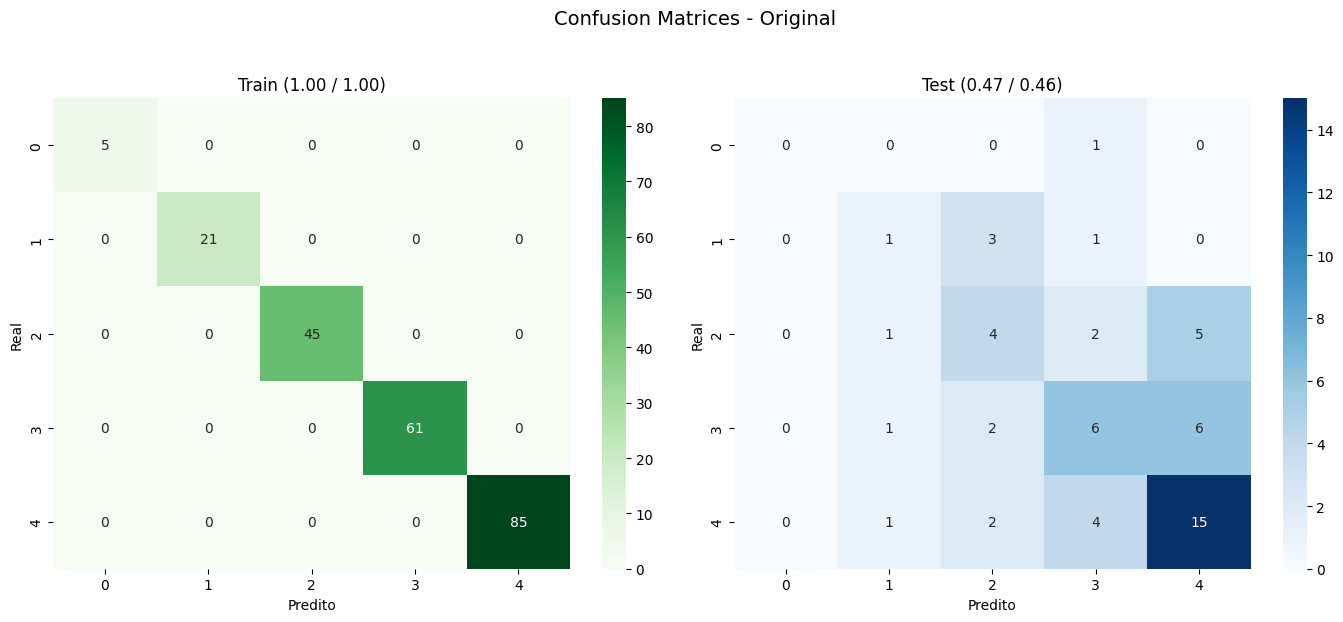


Dataset: Z-Score
--------------------------------------------------
Accuracy  - Train: 1.0000 | Test: 0.4727
F1-Score  - Train: 1.0000 | Test: 0.4589
--------------------------------------------------


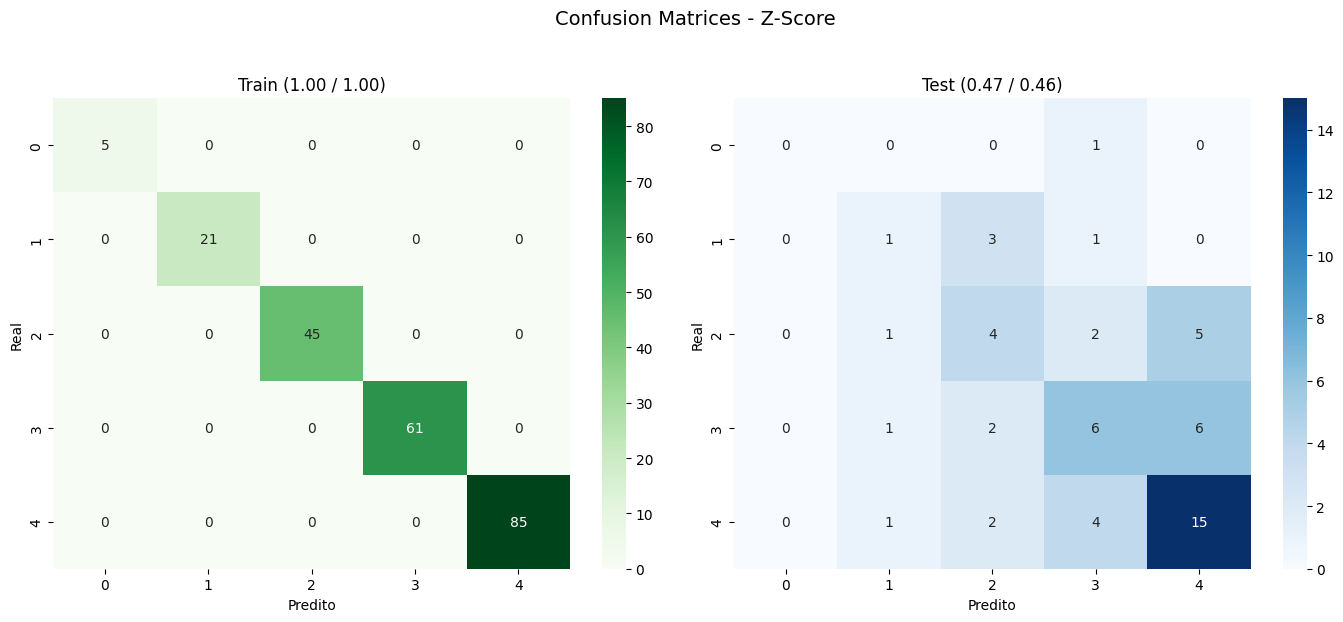


Dataset: Min-Max
--------------------------------------------------
Accuracy  - Train: 1.0000 | Test: 0.4727
F1-Score  - Train: 1.0000 | Test: 0.4589
--------------------------------------------------


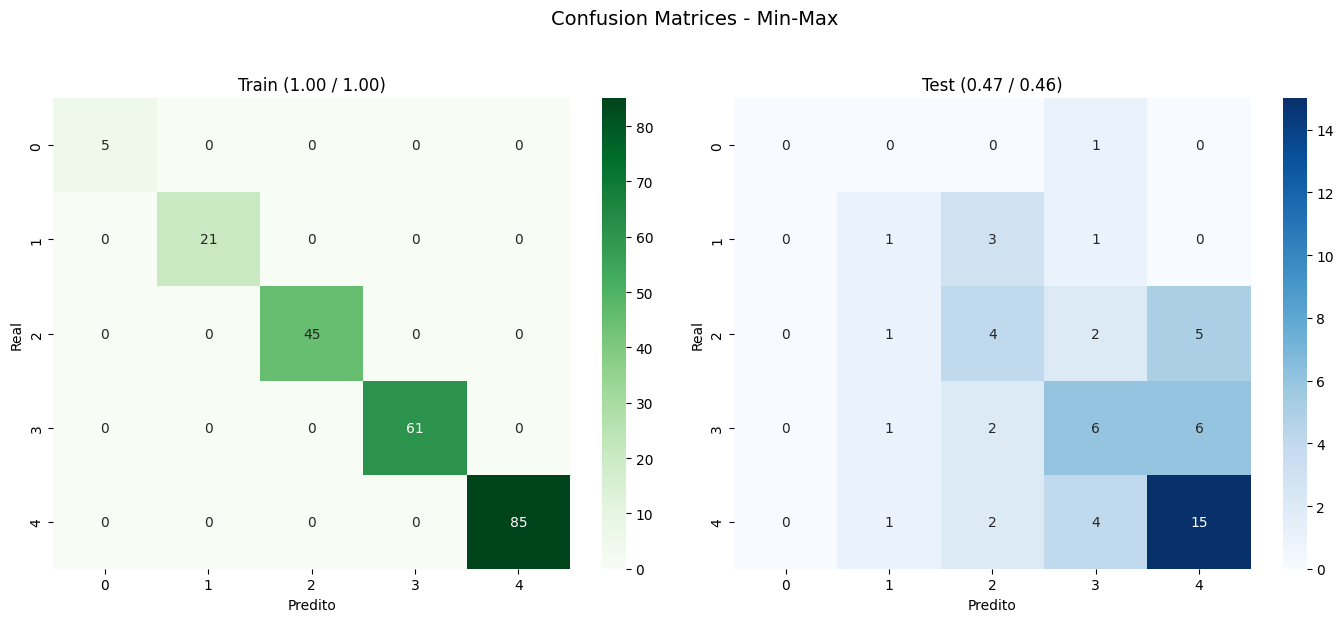


Dataset: SN Min-Max
--------------------------------------------------
Accuracy  - Train: 1.0000 | Test: 0.4727
F1-Score  - Train: 1.0000 | Test: 0.4589
--------------------------------------------------


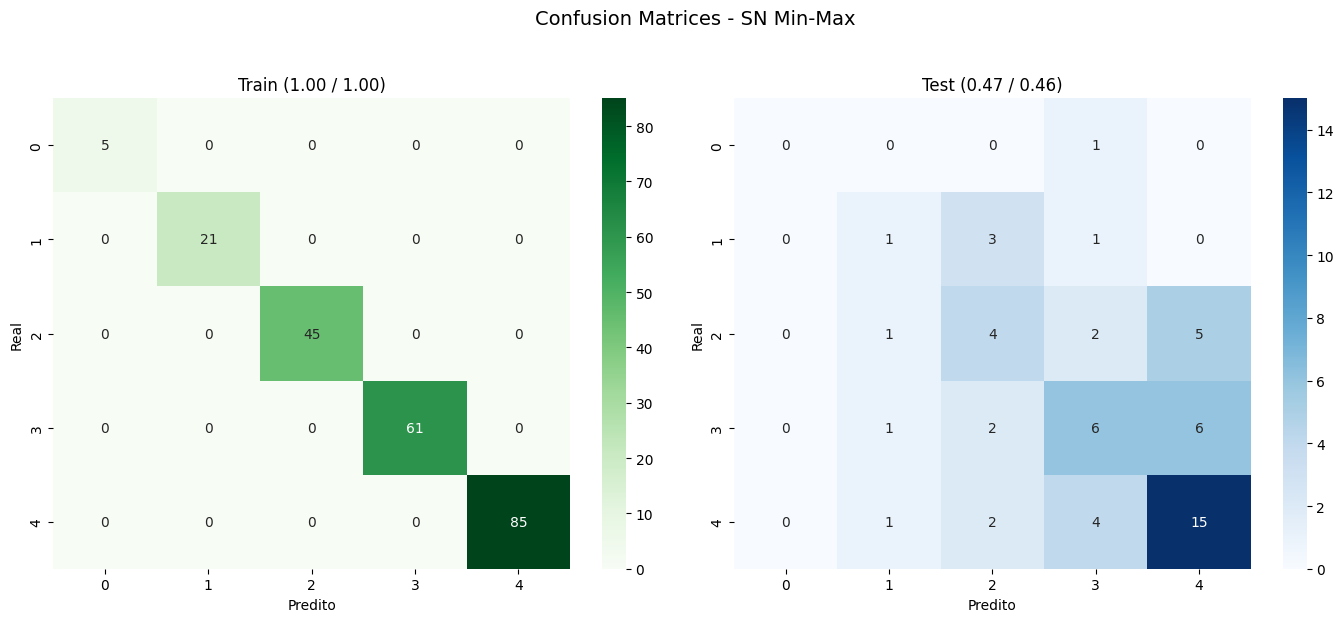


Dataset: SN Z-Score
--------------------------------------------------
Accuracy  - Train: 1.0000 | Test: 0.4727
F1-Score  - Train: 1.0000 | Test: 0.4589
--------------------------------------------------


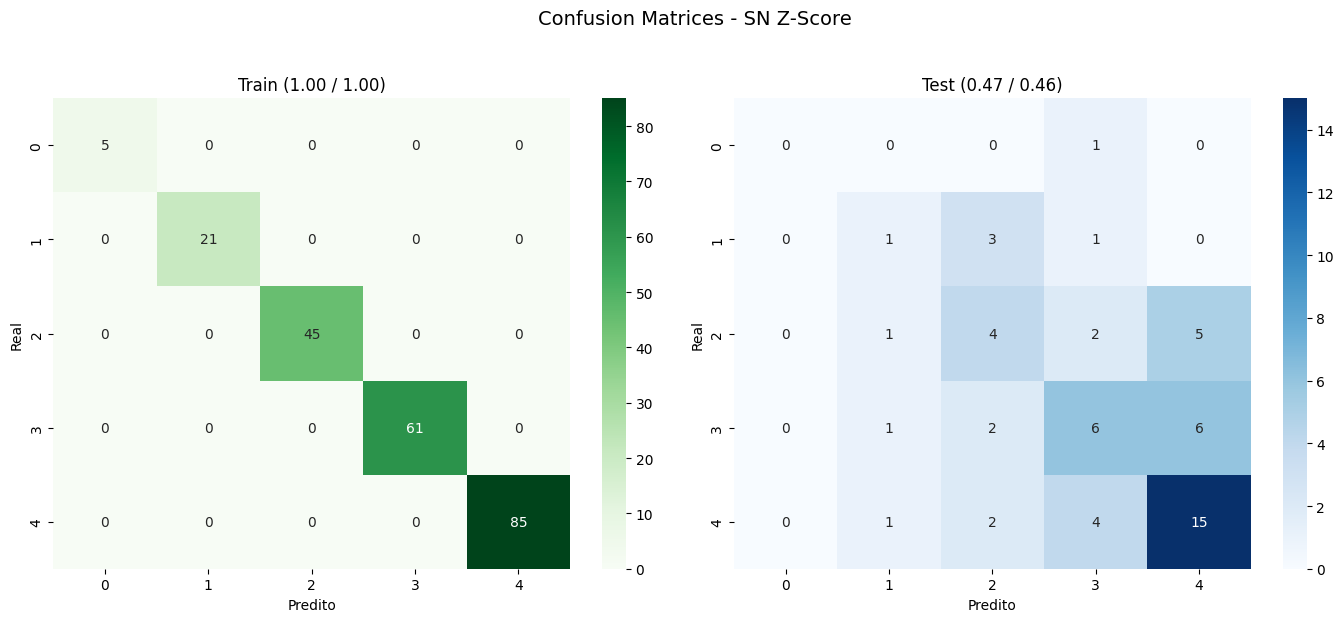

In [43]:
train_file_paths = {
    'Original': r'..\data\task1\features\train\features_raw.csv',
    'Z-Score': r'..\data\task1\features\train\features_z_score.csv',
    'Min-Max': r'..\data\task1\features\train\features_min_max_0_1.csv',
    'SN Min-Max': r'..\data\task1\features\train\features_signal_norm_-1_1_min_max_0_1.csv',
    'SN Z-Score': r'..\data\task1\features\train\features_signal_norm_-1_1_z_score.csv',
}

xgb_params = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss'
}

TEST_SIZE_PERCENTAGE = 0.2
META_COLUMNS = ['ID', 'Class']
results = []

for name, train_path in train_file_paths.items():
    print(f'\nDataset: {name}')
    
    try:
        df_train_full = pd.read_csv(train_path)
    except FileNotFoundError as e:
        print(f'Erro: {e}')
        continue

    if 'Sex' in df_train_full.columns:
        df_train_full['Sex'] = df_train_full['Sex'].map({'M': 0, 'F': 1})

    df_train_full['Class'] = df_train_full['Class'] - 1

    X_full = df_train_full.drop(columns=META_COLUMNS)
    y_full = df_train_full['Class']

    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y_full,
        test_size=TEST_SIZE_PERCENTAGE,
        stratify=y_full,
        random_state=42
    )

    if 'Original' in name:
        scaler = StandardScaler()
        X_train_processed = scaler.fit_transform(X_train)
        X_test_processed = scaler.transform(X_test)
    else:
        X_train_processed = X_train.values
        X_test_processed = X_test.values

    xgb = XGBClassifier(**xgb_params)
    xgb.fit(X_train_processed, y_train)

    y_train_pred = xgb.predict(X_train_processed)
    y_test_pred = xgb.predict(X_test_processed)

    acc_train = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    acc_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    print('-' * 50)
    print(f'Accuracy  - Train: {acc_train:.4f} | Test: {acc_test:.4f}')
    print(f'F1-Score  - Train: {f1_train:.4f} | Test: {f1_test:.4f}')
    print('-' * 50)

    results.append({
        'Dataset': name,
        'Accuracy': acc_test,
        'F1-Score': f1_test
    })

    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    labels = sorted(y_full.unique())

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title(f'Train ({acc_train:.2f} / {f1_train:.2f})')
    axes[0].set_xlabel('Predito')
    axes[0].set_ylabel('Real')

    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title(f'Test ({acc_test:.2f} / {f1_test:.2f})')
    axes[1].set_xlabel('Predito')
    axes[1].set_ylabel('Real')

    plt.suptitle(f'Confusion Matrices - {name}', fontsize=14, y=1.03)
    plt.tight_layout()
    plt.show()

### IDs do Baseline


Dataset: Original
Train: 219 | Teste: 53
--------------------------------------------------
Accuracy - Train: 1.0000 | Test: 0.5283
F1-Score - Train: 1.0000 | Test: 0.5252
--------------------------------------------------


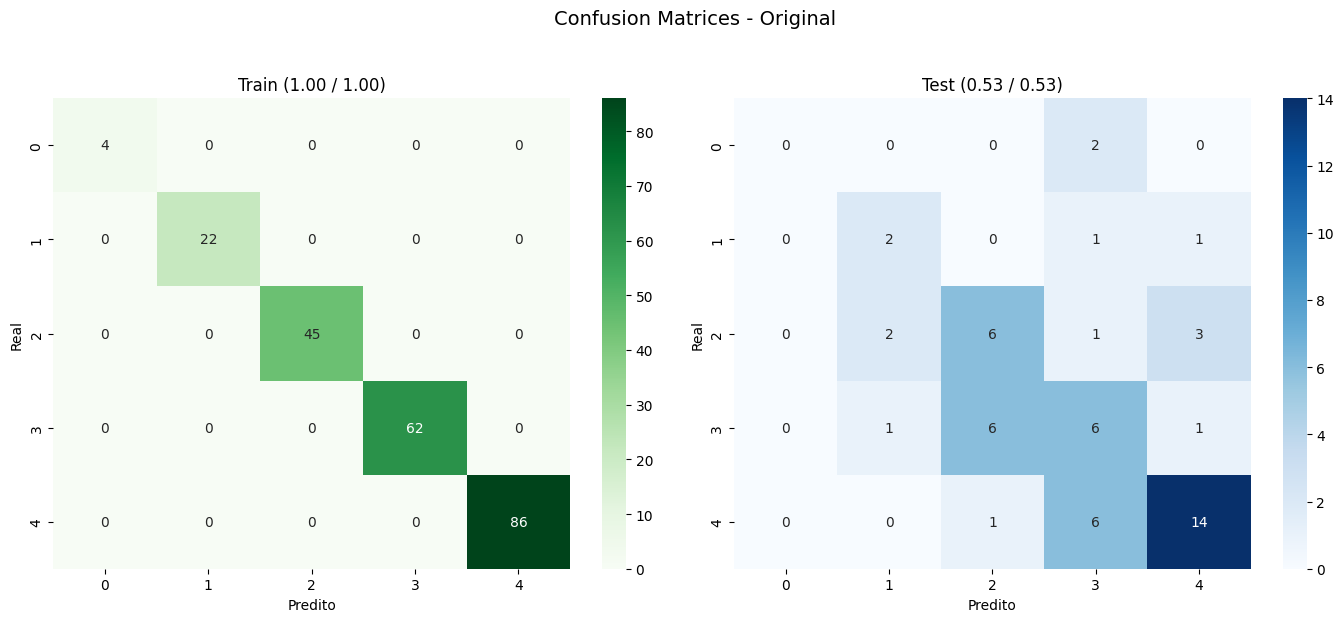


Dataset: Z-Score
Train: 219 | Teste: 53
--------------------------------------------------
Accuracy - Train: 1.0000 | Test: 0.5283
F1-Score - Train: 1.0000 | Test: 0.5252
--------------------------------------------------


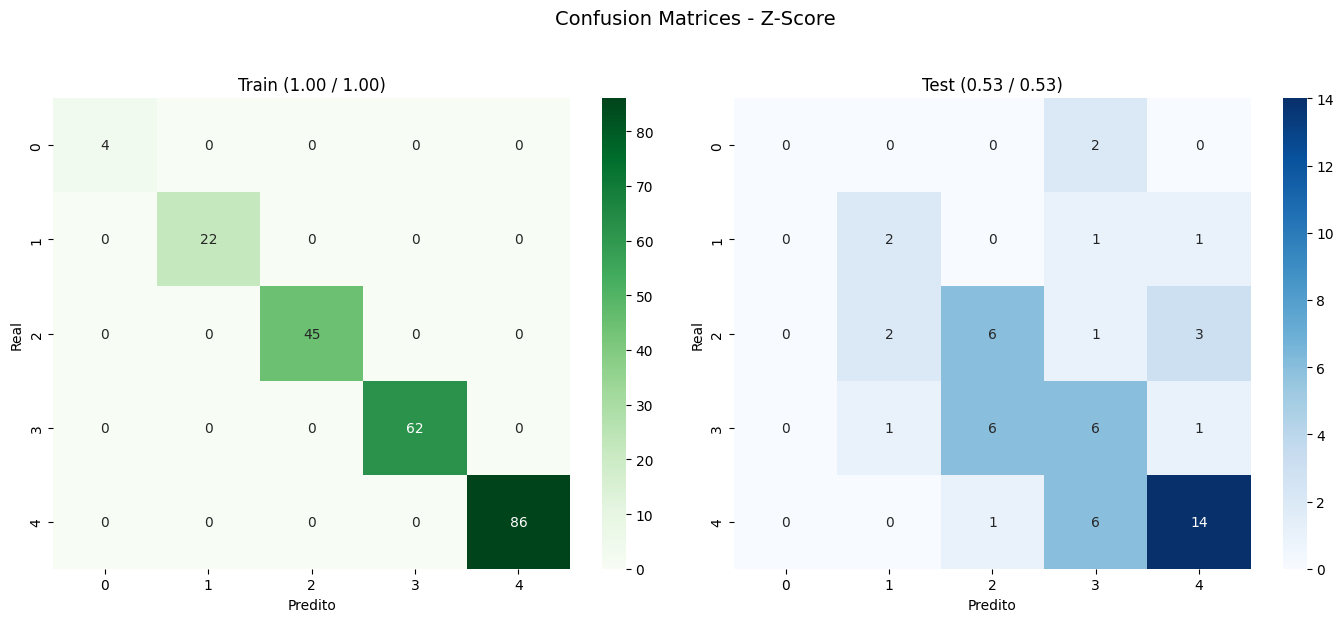


Dataset: Min-Max
Train: 219 | Teste: 53
--------------------------------------------------
Accuracy - Train: 1.0000 | Test: 0.5283
F1-Score - Train: 1.0000 | Test: 0.5252
--------------------------------------------------


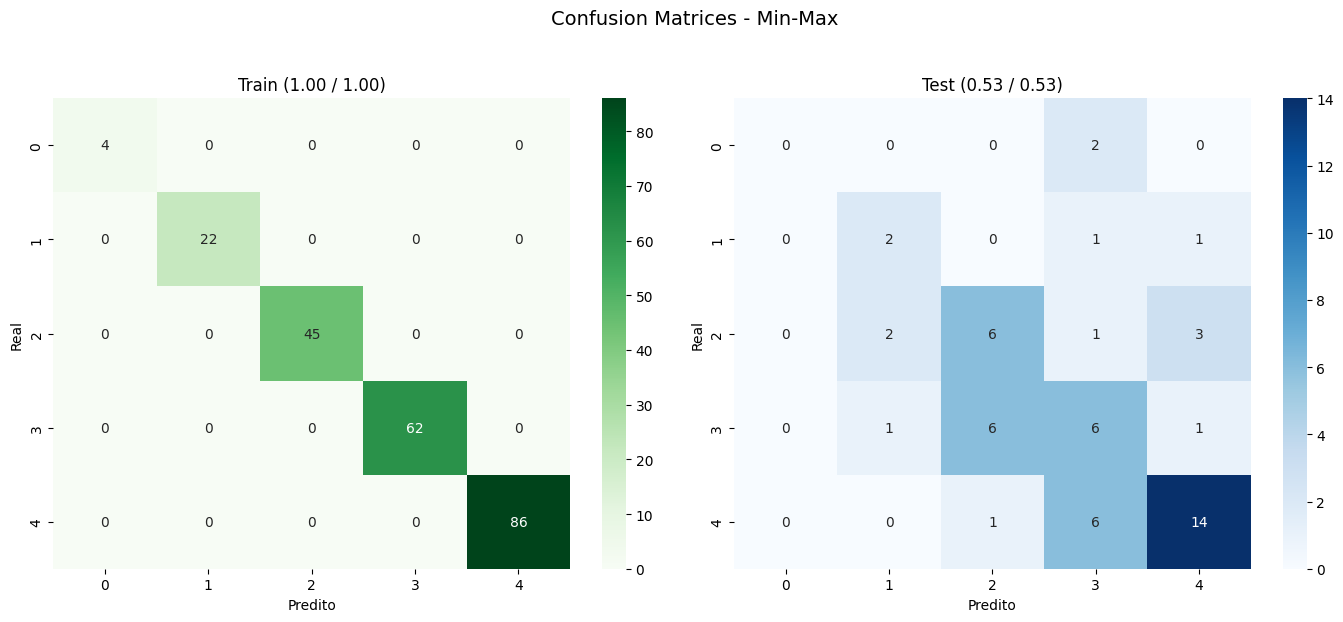


Dataset: SN Min-Max
Train: 219 | Teste: 53
--------------------------------------------------
Accuracy - Train: 1.0000 | Test: 0.5283
F1-Score - Train: 1.0000 | Test: 0.5252
--------------------------------------------------


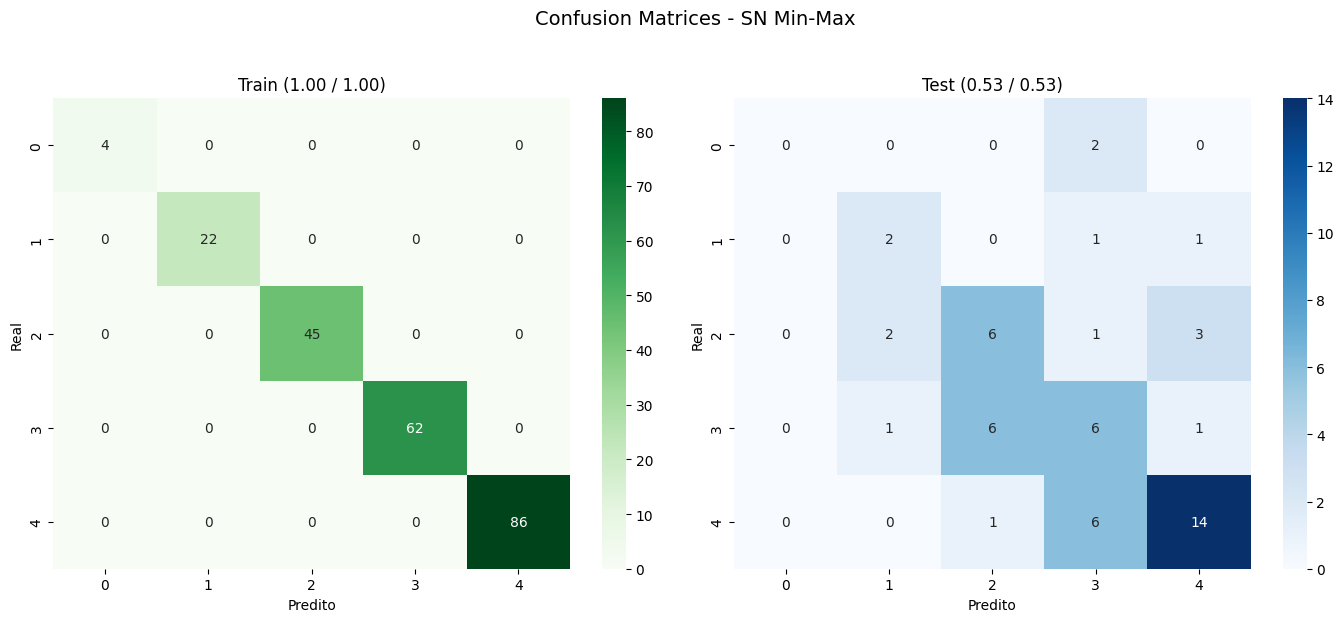


Dataset: SN Z-Score
Train: 219 | Teste: 53
--------------------------------------------------
Accuracy - Train: 1.0000 | Test: 0.5283
F1-Score - Train: 1.0000 | Test: 0.5252
--------------------------------------------------


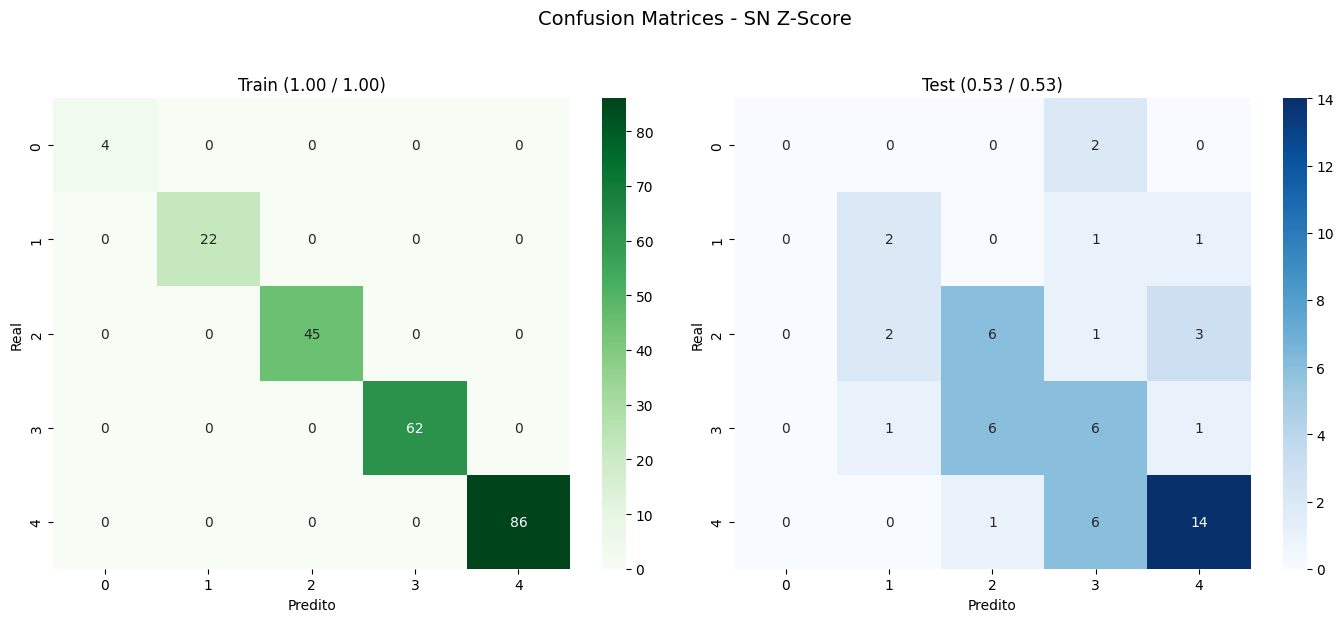

In [45]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

train_file_paths = {
    'Original': r'..\data\task1\features\train\features_raw.csv',
    'Z-Score': r'..\data\task1\features\train\features_z_score.csv',
    'Min-Max': r'..\data\task1\features\train\features_min_max_0_1.csv',
    'SN Min-Max': r'..\data\task1\features\train\features_signal_norm_-1_1_min_max_0_1.csv',
    'SN Z-Score': r'..\data\task1\features\train\features_signal_norm_-1_1_z_score.csv',
}

xgb_params = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss'
}

test_ids = [
    "ID007","ID012","ID021","ID029","ID037","ID046","ID051","ID053","ID054","ID056",
    "ID063","ID075","ID083","ID090","ID099","ID101","ID105","ID110","ID116","ID122",
    "ID129","ID136","ID138","ID140","ID158","ID160","ID164","ID171","ID176","ID179",
    "ID202","ID209","ID227","ID229","ID233","ID245","ID252","ID253","ID260","ID261",
    "ID263","ID264","ID269","ID270","ID274","ID278","ID284","ID286","ID290","ID302",
    "ID306","ID323","ID329"
]

META_COLUMNS = ['ID', 'Class']
results = []

for name, train_path in train_file_paths.items():
    print(f'\nDataset: {name}')
    
    try:
        df_train_full = pd.read_csv(train_path)
    except FileNotFoundError as e:
        print(f'Erro: {e}')
        continue

    if 'Sex' in df_train_full.columns:
        df_train_full['Sex'] = df_train_full['Sex'].map({'M': 0, 'F': 1})
        
    df_train_full['Class'] = df_train_full['Class'] - 1

    df_test = df_train_full[df_train_full['ID'].isin(test_ids)].copy()
    df_train = df_train_full[~df_train_full['ID'].isin(test_ids)].copy()

    X_train = df_train.drop(columns=META_COLUMNS)
    y_train = df_train['Class']
    
    X_test = df_test.drop(columns=META_COLUMNS)
    y_test = df_test['Class']

    print(f'Train: {len(X_train)} | Teste: {len(X_test)}')
    
    if 'Original' in name:
        scaler = StandardScaler()
        X_train_processed = scaler.fit_transform(X_train)
        X_test_processed = scaler.transform(X_test)
    else:
        X_train_processed = X_train.values
        X_test_processed = X_test.values

    xgb = XGBClassifier(**xgb_params)
    xgb.fit(X_train_processed, y_train)

    y_train_pred = xgb.predict(X_train_processed)
    y_test_pred = xgb.predict(X_test_processed)

    acc_train = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    acc_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    print('-' * 50)
    print(f'Accuracy - Train: {acc_train:.4f} | Test: {acc_test:.4f}')
    print(f'F1-Score - Train: {f1_train:.4f} | Test: {f1_test:.4f}')
    print('-' * 50)

    results.append({
        'Dataset': name,
        'Accuracy': acc_test,
        'F1-Score': f1_test
    })

    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    labels = sorted(df_train_full['Class'].unique()) 

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title(f'Train ({acc_train:.2f} / {f1_train:.2f})')
    axes[0].set_xlabel('Predito')
    axes[0].set_ylabel('Real')

    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title(f'Test ({acc_test:.2f} / {f1_test:.2f})')
    axes[1].set_xlabel('Predito')
    axes[1].set_ylabel('Real')

    plt.suptitle(f'Confusion Matrices - {name}', fontsize=14, y=1.03)
    plt.tight_layout()
    plt.show()

## Features Thiago

### Divisão aleatória


Dataset: Thiago Pivot (XGBoost)
--------------------------------------------------
Accuracy - Train: 1.0000 | Test: 0.5818
F1-Score - Train: 1.0000 | Test: 0.5435
--------------------------------------------------


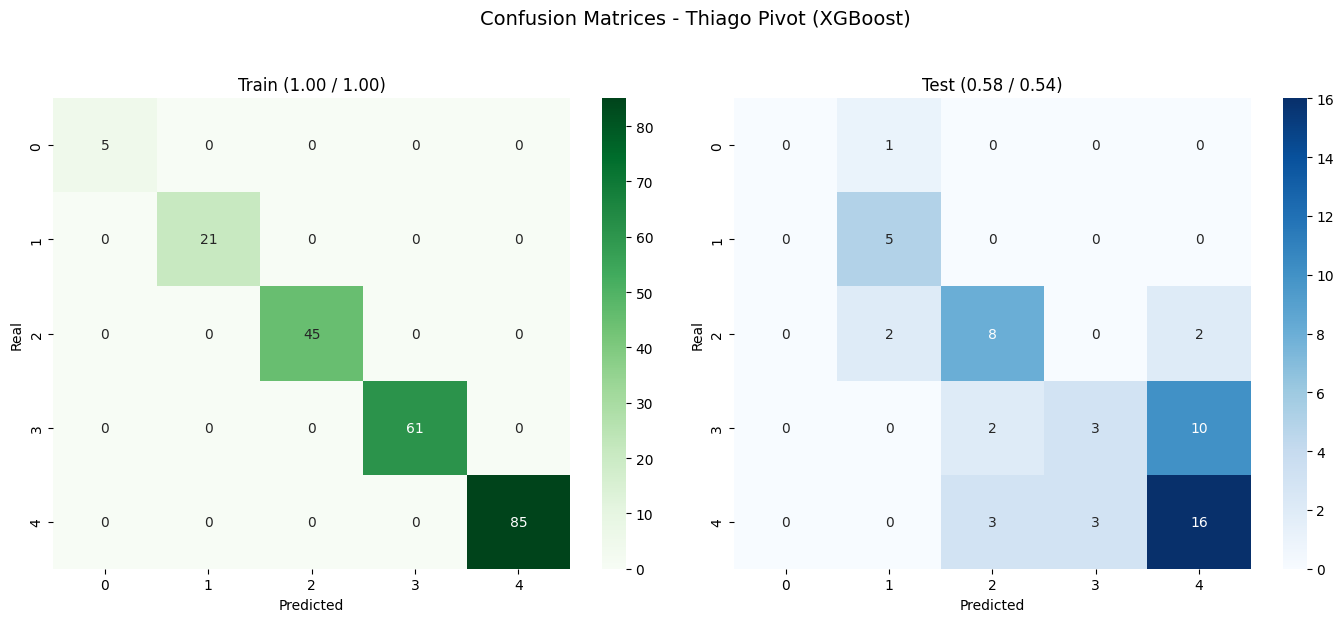

In [49]:
train_file_path = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\task1\features\train\features_thiago_pivot.csv'

xgb_params = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss'
}

TEST_SIZE_PERCENTAGE = 0.2
META_COLUMNS = ['ID', 'Class']

df_train_full = pd.read_csv(train_file_path)

if 'Sex' in df_train_full.columns:
    df_train_full['Sex'] = df_train_full['Sex'].map({'M': 0, 'F': 1})

df_train_full['Class'] = df_train_full['Class'] - 1

df_train_full = df_train_full.dropna(axis=1, how='all')

def try_parse_array(x):
    try:
        val = literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
        if isinstance(val, (list, tuple, np.ndarray)):
            return np.mean(val)
        return val
    except Exception:
        return x

for col in df_train_full.columns:
    if df_train_full[col].astype(str).str.startswith('[').any():
        df_train_full[col] = df_train_full[col].apply(try_parse_array)

X_full_orig = df_train_full.drop(columns=META_COLUMNS)
y_full = df_train_full['Class']
X_full_orig = X_full_orig.select_dtypes(include=[np.number])

X_train_orig, X_test_orig, y_train, y_test = train_test_split(
    X_full_orig, y_full, test_size=TEST_SIZE_PERCENTAGE, stratify=y_full, random_state=42
)

scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train_orig)
X_test_processed = scaler.transform(X_test_orig)

xgb = XGBClassifier(**xgb_params)
xgb.fit(X_train_processed, y_train)

y_train_pred = xgb.predict(X_train_processed)
y_test_pred = xgb.predict(X_test_processed)

acc_train = accuracy_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred, average='weighted')
acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print(f'\nDataset: Thiago Pivot (XGBoost)')
print('-' * 50)
print(f'Accuracy - Train: {acc_train:.4f} | Test: {acc_test:.4f}')
print(f'F1-Score - Train: {f1_train:.4f} | Test: {f1_test:.4f}')
print('-' * 50)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
labels = sorted(y_full.unique())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title(f'Train ({acc_train:.2f} / {f1_train:.2f})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Real')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title(f'Test ({acc_test:.2f} / {f1_test:.2f})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Real')

plt.suptitle(f'Confusion Matrices - Thiago Pivot (XGBoost)', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

### IDs do Baseline


Dataset: Thiago Pivot (XGBoost com Test IDs Específicos)
--------------------------------------------------
Tamanho Treino: 219 | Tamanho Teste: 53
Accuracy - Train: 0.9954 | Test: 0.4717
F1-Score - Train: 0.9954 | Test: 0.4724
--------------------------------------------------


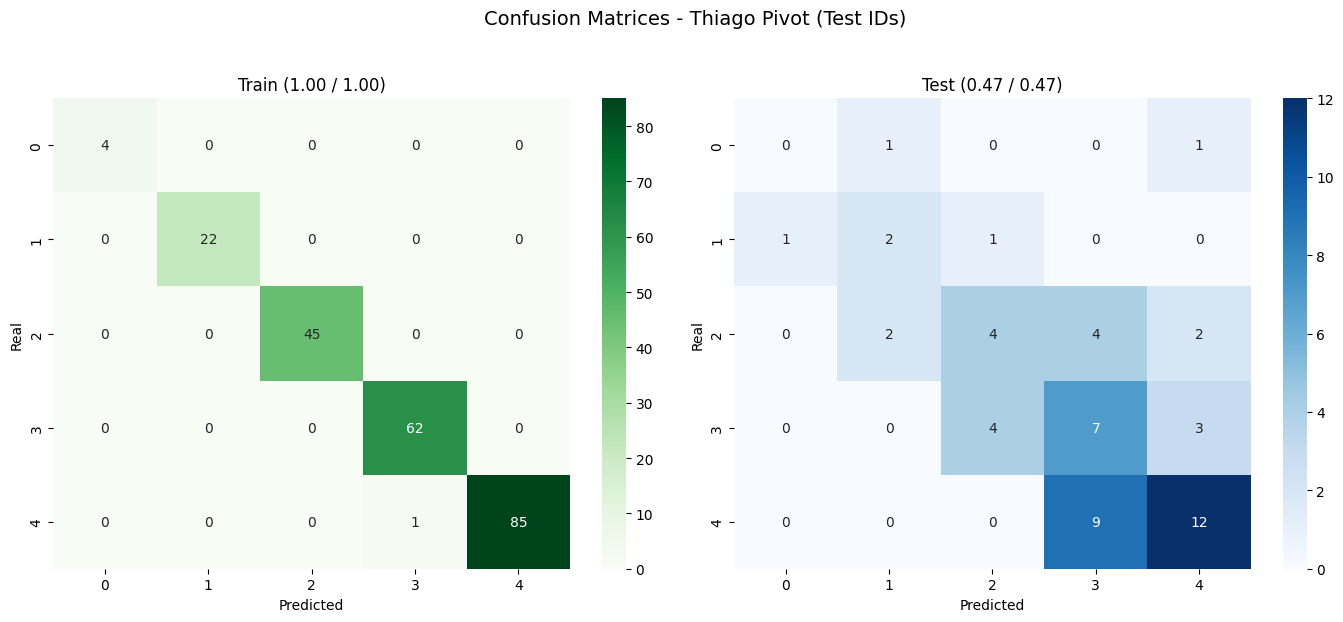

In [51]:
train_file_path = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\task1\features\train\features_thiago_pivot.csv'

xgb_params = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'gamma': 0.1,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'multi:softmax',
    'eval_metric': 'mlogloss'
}

test_ids = [
    "ID007","ID012","ID021","ID029","ID037","ID046","ID051","ID053","ID054","ID056",
    "ID063","ID075","ID083","ID090","ID099","ID101","ID105","ID110","ID116","ID122",
    "ID129","ID136","ID138","ID140","ID158","ID160","ID164","ID171","ID176","ID179",
    "ID202","ID209","ID227","ID229","ID233","ID245","ID252","ID253","ID260","ID261",
    "ID263","ID264","ID269","ID270","ID274","ID278","ID284","ID286","ID290","ID302",
    "ID306","ID323","ID329"
]

META_COLUMNS = ['ID', 'Class']

df_train_full = pd.read_csv(train_file_path)

if 'Sex' in df_train_full.columns:
    df_train_full['Sex'] = df_train_full['Sex'].map({'M': 0, 'F': 1})

df_train_full['Class'] = df_train_full['Class'] - 1

df_train_full = df_train_full.dropna(axis=1, how='all')

def try_parse_array(x):
    try:
        val = literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
        if isinstance(val, (list, tuple, np.ndarray)):
            return np.mean(val)
        return val
    except Exception:
        return x

for col in df_train_full.columns:
    if df_train_full[col].astype(str).str.startswith('[').any():
        df_train_full[col] = df_train_full[col].apply(try_parse_array)

df_test = df_train_full[df_train_full['ID'].isin(test_ids)].copy()
df_train = df_train_full[~df_train_full['ID'].isin(test_ids)].copy()

X_full_orig = df_train_full.drop(columns=META_COLUMNS)
X_full_orig = X_full_orig.select_dtypes(include=[np.number])
y_full = df_train_full['Class']

X_train_orig = df_train.drop(columns=META_COLUMNS).select_dtypes(include=[np.number])
y_train = df_train['Class']

X_test_orig = df_test.drop(columns=META_COLUMNS).select_dtypes(include=[np.number])
y_test = df_test['Class']

scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train_orig)
X_test_processed = scaler.transform(X_test_orig)

xgb = XGBClassifier(**xgb_params)
xgb.fit(X_train_processed, y_train)

y_train_pred = xgb.predict(X_train_processed)
y_test_pred = xgb.predict(X_test_processed)

acc_train = accuracy_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred, average='weighted')
acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print(f'\nDataset: Thiago Pivot (XGBoost com Test IDs Específicos)')
print('-' * 50)
print(f'Tamanho Treino: {len(X_train_orig)} | Tamanho Teste: {len(X_test_orig)}')
print(f'Accuracy - Train: {acc_train:.4f} | Test: {acc_test:.4f}')
print(f'F1-Score - Train: {f1_train:.4f} | Test: {f1_test:.4f}')
print('-' * 50)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
labels = sorted(y_full.unique())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title(f'Train ({acc_train:.2f} / {f1_train:.2f})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Real')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title(f'Test ({acc_test:.2f} / {f1_test:.2f})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Real')

plt.suptitle(f'Confusion Matrices - Thiago Pivot (Test IDs)', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

# LightGBM

## Features João

### Divisão aleatória


Dataset: Original
--------------------------------------------------
Accuracy - Train: 1.0000 | Test: 0.4545
F1-Score - Train: 1.0000 | Test: 0.4501
--------------------------------------------------


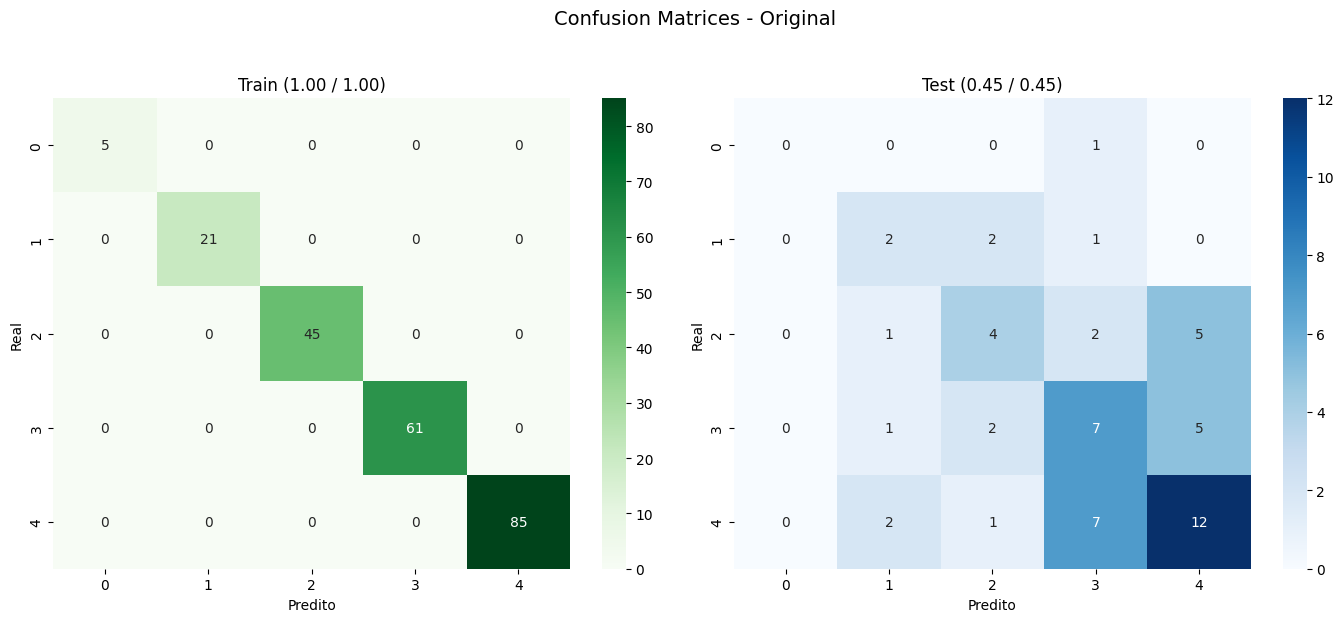


Dataset: Z-Score
--------------------------------------------------
Accuracy - Train: 0.9954 | Test: 0.4545
F1-Score - Train: 0.9954 | Test: 0.4489
--------------------------------------------------


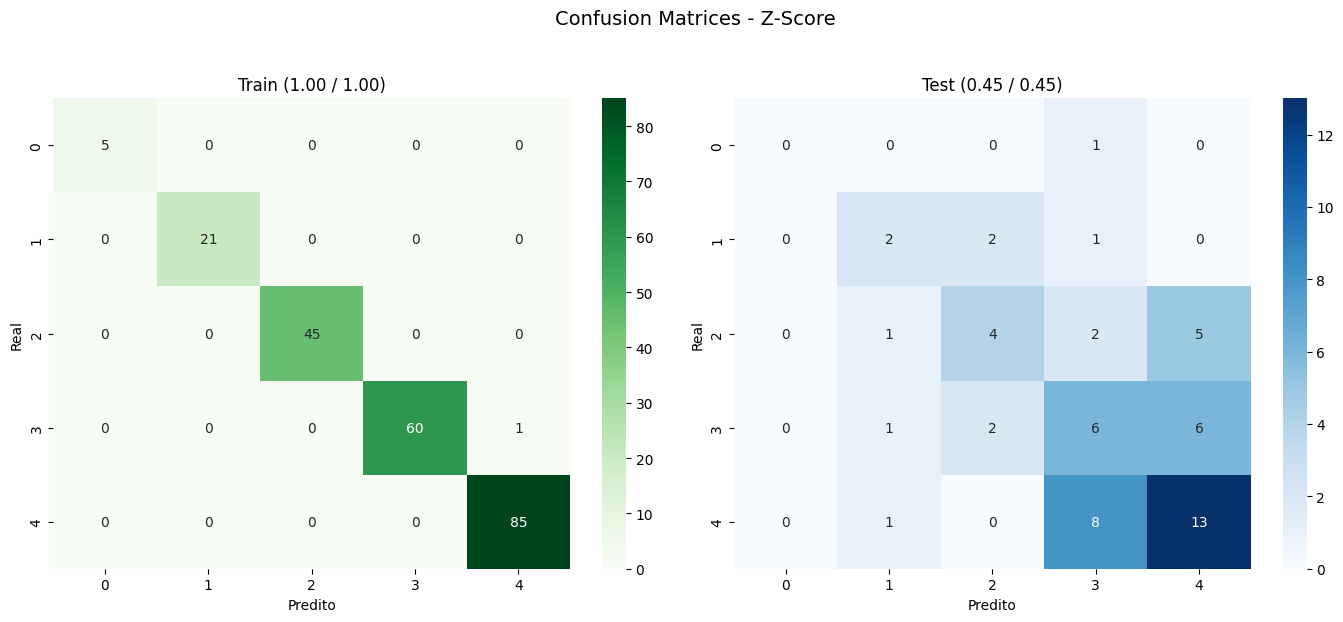


Dataset: Min-Max
--------------------------------------------------
Accuracy - Train: 0.9954 | Test: 0.4364
F1-Score - Train: 0.9954 | Test: 0.4265
--------------------------------------------------


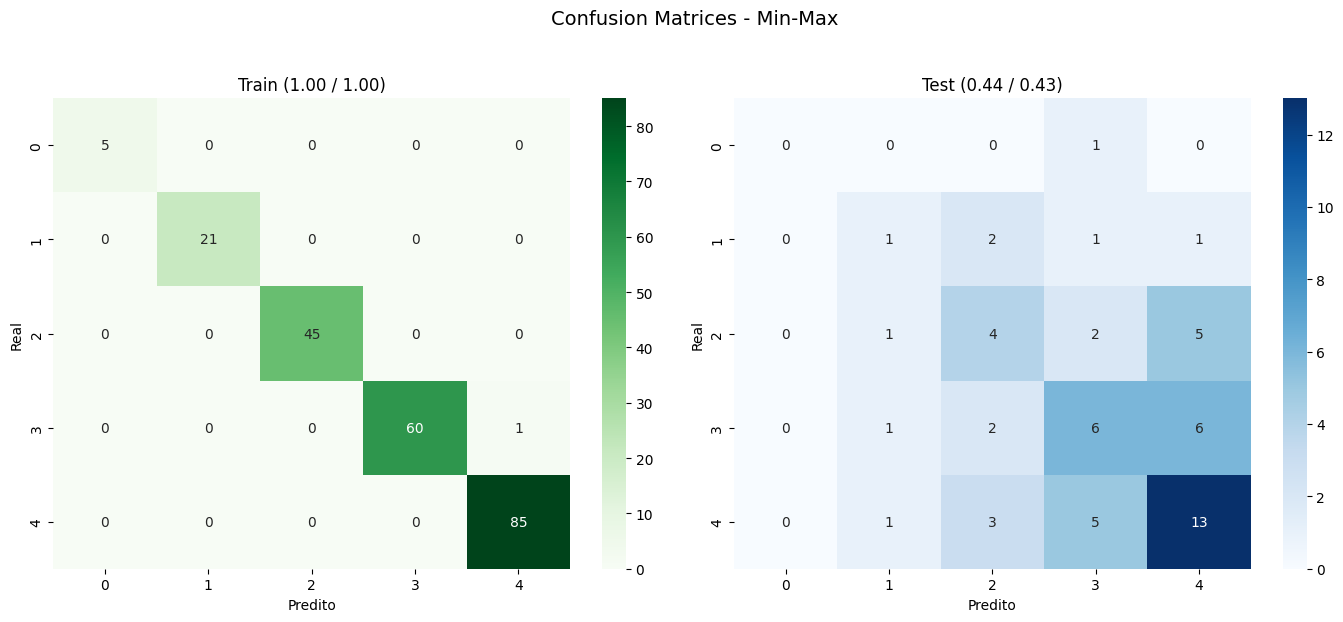


Dataset: SN Min-Max
--------------------------------------------------
Accuracy - Train: 0.9954 | Test: 0.4364
F1-Score - Train: 0.9954 | Test: 0.4265
--------------------------------------------------


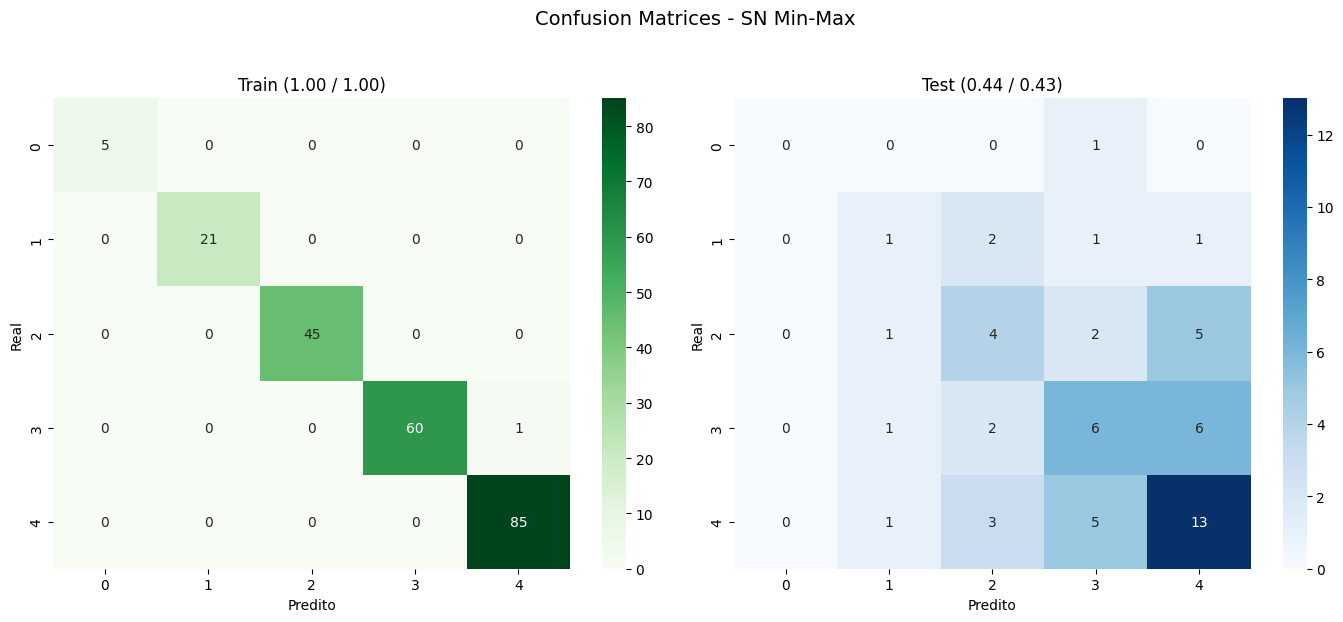


Dataset: SN Z-Score
--------------------------------------------------
Accuracy - Train: 0.9954 | Test: 0.4545
F1-Score - Train: 0.9954 | Test: 0.4489
--------------------------------------------------


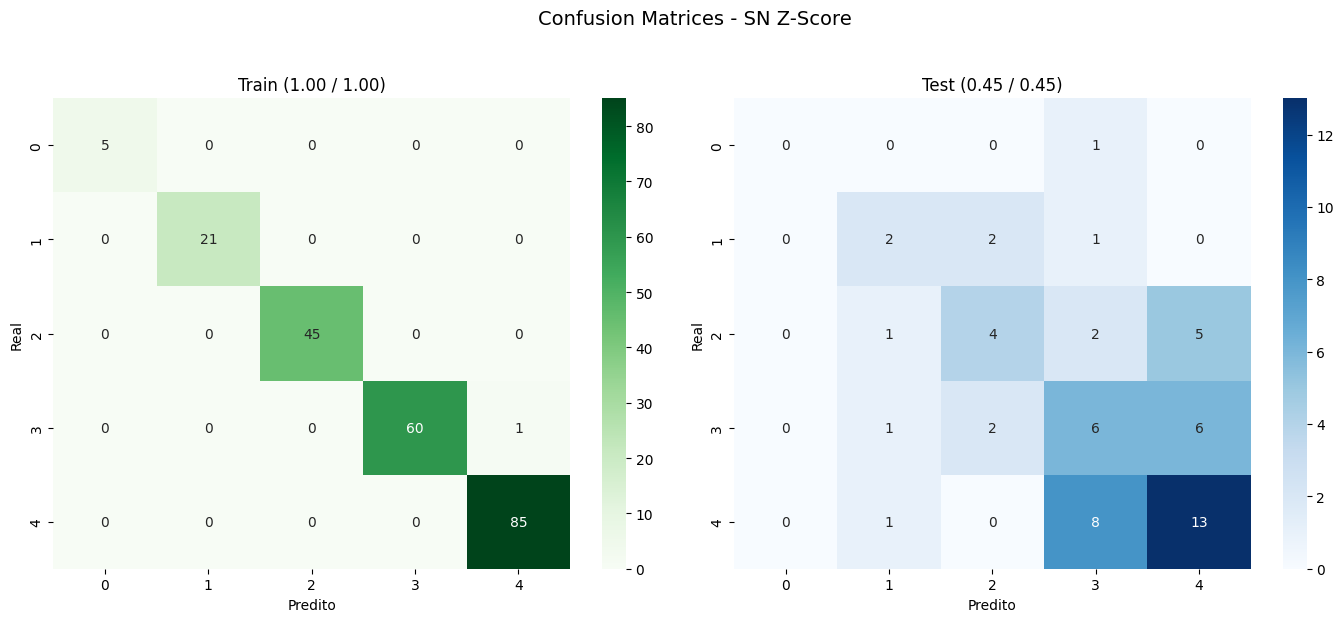

In [64]:
train_file_paths = {
    'Original': r'..\data\task1\features\train\features_raw.csv',
    'Z-Score': r'..\data\task1\features\train\features_z_score.csv',
    'Min-Max': r'..\data\task1\features\train\features_min_max_0_1.csv',
    'SN Min-Max': r'..\data\task1\features\train\features_signal_norm_-1_1_min_max_0_1.csv',
    'SN Z-Score': r'..\data\task1\features\train\features_signal_norm_-1_1_z_score.csv',
}

lgbm_params = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'multiclass',
    'num_class': 5
}

TEST_SIZE_PERCENTAGE = 0.2
META_COLUMNS = ['ID', 'Class']
results = []

for name, train_path in train_file_paths.items():
    print(f'\nDataset: {name}')
    
    try:
        df_train_full = pd.read_csv(train_path)
    except FileNotFoundError as e:
        print(f'Erro: {e}')
        continue

    if 'Sex' in df_train_full.columns:
        df_train_full['Sex'] = df_train_full['Sex'].map({'M': 0, 'F': 1})

    df_train_full['Class'] = df_train_full['Class'] - 1

    X_full = df_train_full.drop(columns=META_COLUMNS)
    y_full = df_train_full['Class']

    X_train, X_test, y_train, y_test = train_test_split(
        X_full, y_full,
        test_size=TEST_SIZE_PERCENTAGE,
        stratify=y_full,
        random_state=42
    )

    if 'Original' in name:
        scaler = StandardScaler()
        X_train_processed = scaler.fit_transform(X_train)
        X_test_processed = scaler.transform(X_test)
    else:
        X_train_processed = X_train.values
        X_test_processed = X_test.values

    lgbm = LGBMClassifier(**lgbm_params)
    lgbm.fit(X_train_processed, y_train)

    y_train_pred = lgbm.predict(X_train_processed)
    y_test_pred = lgbm.predict(X_test_processed)

    acc_train = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    acc_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    print('-' * 50)
    print(f'Accuracy - Train: {acc_train:.4f} | Test: {acc_test:.4f}')
    print(f'F1-Score - Train: {f1_train:.4f} | Test: {f1_test:.4f}')
    print('-' * 50)

    results.append({
        'Dataset': name,
        'Accuracy': acc_test,
        'F1-Score': f1_test
    })

    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    labels = sorted(y_full.unique())

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title(f'Train ({acc_train:.2f} / {f1_train:.2f})')
    axes[0].set_xlabel('Predito')
    axes[0].set_ylabel('Real')

    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title(f'Test ({acc_test:.2f} / {f1_test:.2f})')
    axes[1].set_xlabel('Predito')
    axes[1].set_ylabel('Real')

    plt.suptitle(f'Confusion Matrices - {name}', fontsize=14, y=1.03)
    plt.tight_layout()
    plt.show()

### IDs do Baseline


Dataset: Original
Train: 219 | Test : 53
--------------------------------------------------
Accuracy - Train: 0.9954 | Test: 0.6038
F1-Score - Train: 0.9952 | Test: 0.6004
--------------------------------------------------


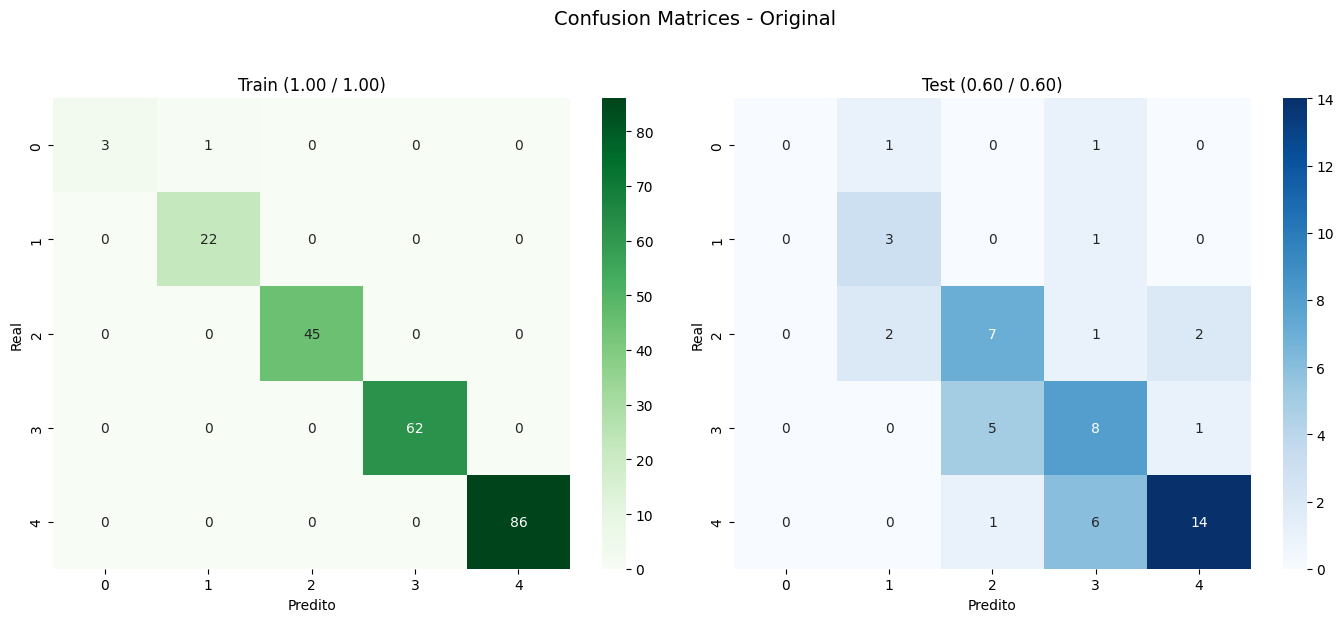


Dataset: Z-Score
Train: 219 | Test : 53
--------------------------------------------------
Accuracy - Train: 0.9954 | Test: 0.5849
F1-Score - Train: 0.9952 | Test: 0.5791
--------------------------------------------------


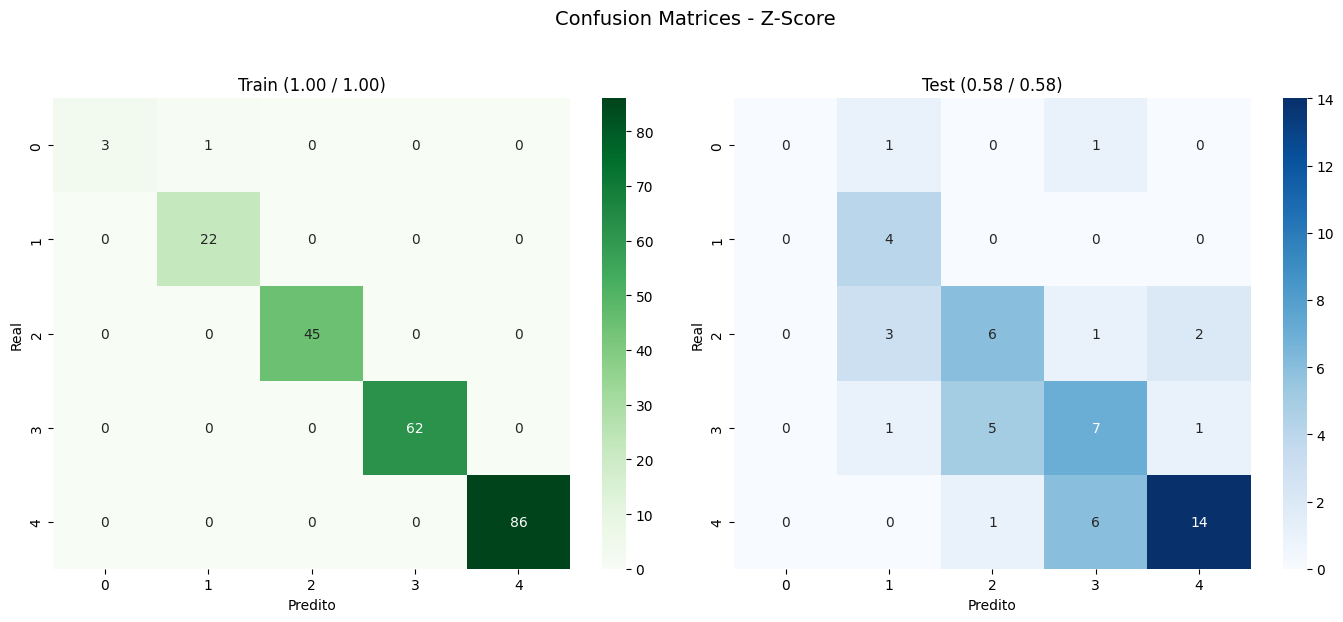


Dataset: Min-Max
Train: 219 | Test : 53
--------------------------------------------------
Accuracy - Train: 0.9954 | Test: 0.5660
F1-Score - Train: 0.9952 | Test: 0.5572
--------------------------------------------------


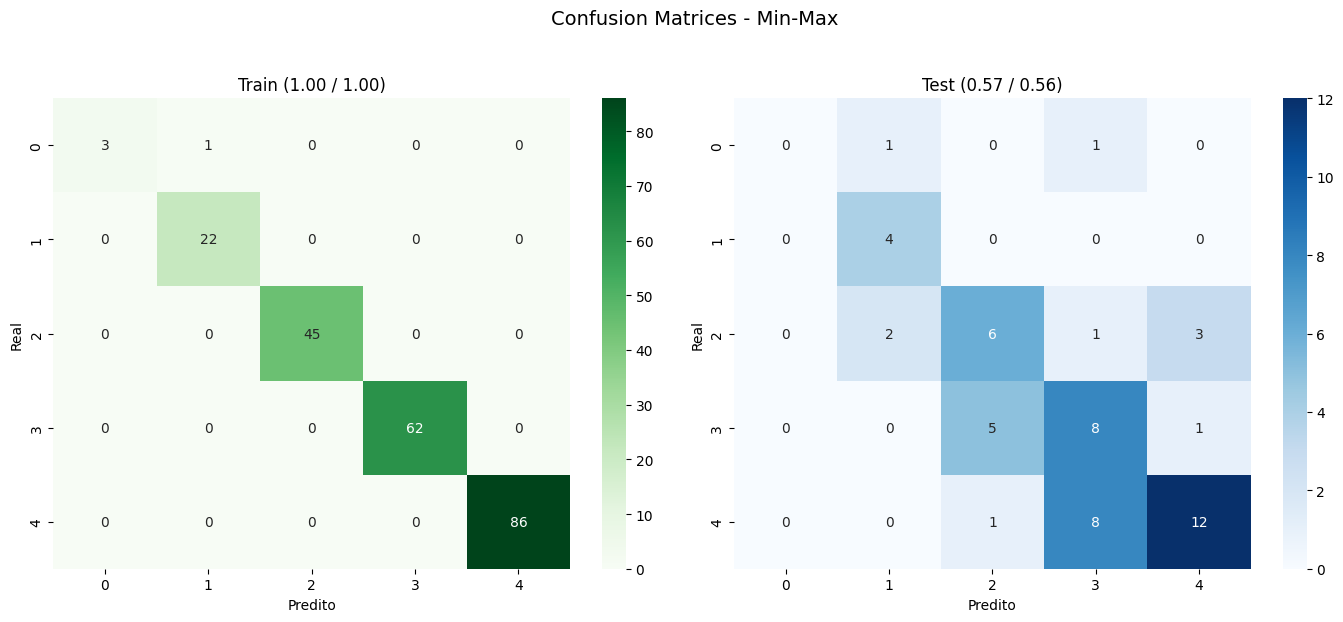


Dataset: SN Min-Max
Train: 219 | Test : 53
--------------------------------------------------
Accuracy - Train: 0.9954 | Test: 0.5660
F1-Score - Train: 0.9952 | Test: 0.5572
--------------------------------------------------


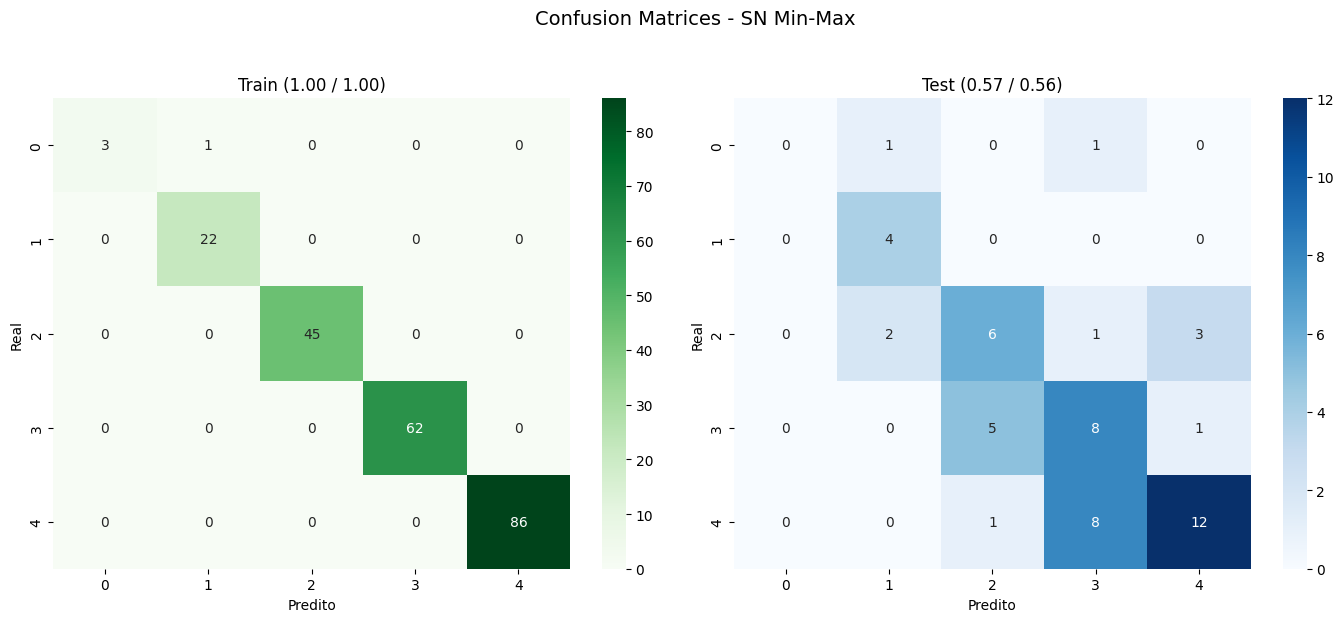


Dataset: SN Z-Score
Train: 219 | Test : 53
--------------------------------------------------
Accuracy - Train: 0.9954 | Test: 0.5849
F1-Score - Train: 0.9952 | Test: 0.5791
--------------------------------------------------


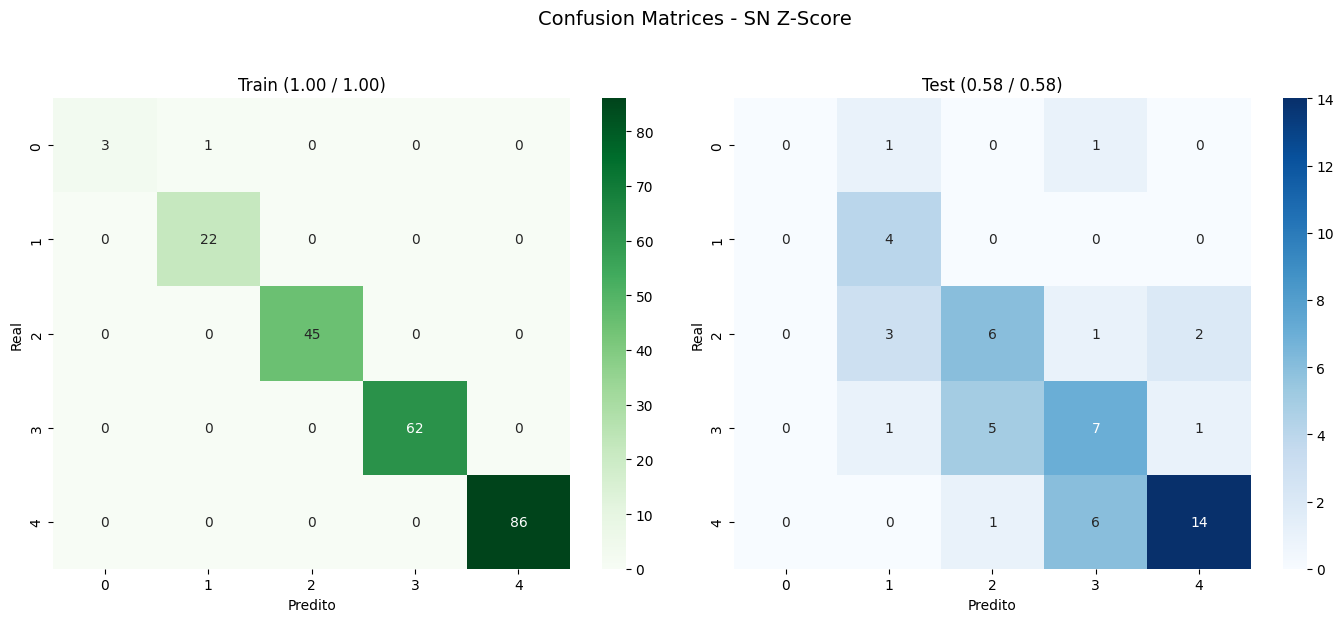

In [66]:
train_file_paths = {
    'Original': r'..\data\task1\features\train\features_raw.csv',
    'Z-Score': r'..\data\task1\features\train\features_z_score.csv',
    'Min-Max': r'..\data\task1\features\train\features_min_max_0_1.csv',
    'SN Min-Max': r'..\data\task1\features\train\features_signal_norm_-1_1_min_max_0_1.csv',
    'SN Z-Score': r'..\data\task1\features\train\features_signal_norm_-1_1_z_score.csv',
}

lgbm_params = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'multiclass',
    'num_class': 5
}

test_ids = [
    "ID007","ID012","ID021","ID029","ID037","ID046","ID051","ID053","ID054","ID056",
    "ID063","ID075","ID083","ID090","ID099","ID101","ID105","ID110","ID116","ID122",
    "ID129","ID136","ID138","ID140","ID158","ID160","ID164","ID171","ID176","ID179",
    "ID202","ID209","ID227","ID229","ID233","ID245","ID252","ID253","ID260","ID261",
    "ID263","ID264","ID269","ID270","ID274","ID278","ID284","ID286","ID290","ID302",
    "ID306","ID323","ID329"
]

META_COLUMNS = ['ID', 'Class']
results = []

for name, train_path in train_file_paths.items():
    print(f'\nDataset: {name}')
    
    try:
        df_train_full = pd.read_csv(train_path)
    except FileNotFoundError as e:
        print(f'Erro: {e}')
        continue

    if 'Sex' in df_train_full.columns:
        df_train_full['Sex'] = df_train_full['Sex'].map({'M': 0, 'F': 1})

    df_train_full['Class'] = df_train_full['Class'] - 1

    df_test = df_train_full[df_train_full['ID'].isin(test_ids)].copy()
    df_train = df_train_full[~df_train_full['ID'].isin(test_ids)].copy()

    X_train = df_train.drop(columns=META_COLUMNS)
    y_train = df_train['Class']
    
    X_test = df_test.drop(columns=META_COLUMNS)
    y_test = df_test['Class']
    
    print(f'Train: {len(X_train)} | Test : {len(X_test)}')


    if 'Original' in name:
        scaler = StandardScaler()
        X_train_processed = scaler.fit_transform(X_train)
        X_test_processed = scaler.transform(X_test)
    else:
        X_train_processed = X_train.values
        X_test_processed = X_test.values

    lgbm = LGBMClassifier(**lgbm_params)
    lgbm.fit(X_train_processed, y_train)

    y_train_pred = lgbm.predict(X_train_processed)
    y_test_pred = lgbm.predict(X_test_processed)

    acc_train = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    acc_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    print('-' * 50)
    print(f'Accuracy - Train: {acc_train:.4f} | Test: {acc_test:.4f}')
    print(f'F1-Score - Train: {f1_train:.4f} | Test: {f1_test:.4f}')
    print('-' * 50)

    results.append({
        'Dataset': name,
        'Accuracy': acc_test,
        'F1-Score': f1_test
    })

    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    labels = sorted(df_train_full['Class'].unique())

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title(f'Train ({acc_train:.2f} / {f1_train:.2f})')
    axes[0].set_xlabel('Predito')
    axes[0].set_ylabel('Real')

    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title(f'Test ({acc_test:.2f} / {f1_test:.2f})')
    axes[1].set_xlabel('Predito')
    axes[1].set_ylabel('Real')

    plt.suptitle(f'Confusion Matrices - {name}', fontsize=14, y=1.03)
    plt.tight_layout()
    plt.show()

## Features Thiago

### Divisão aleatória


Dataset: Thiago Pivot
--------------------------------------------------
Tamanho Treino: 219 | Tamanho Teste: 53
Accuracy - Train: 0.9817 | Test: 0.5094
F1-Score - Train: 0.9781 | Test: 0.5036
--------------------------------------------------


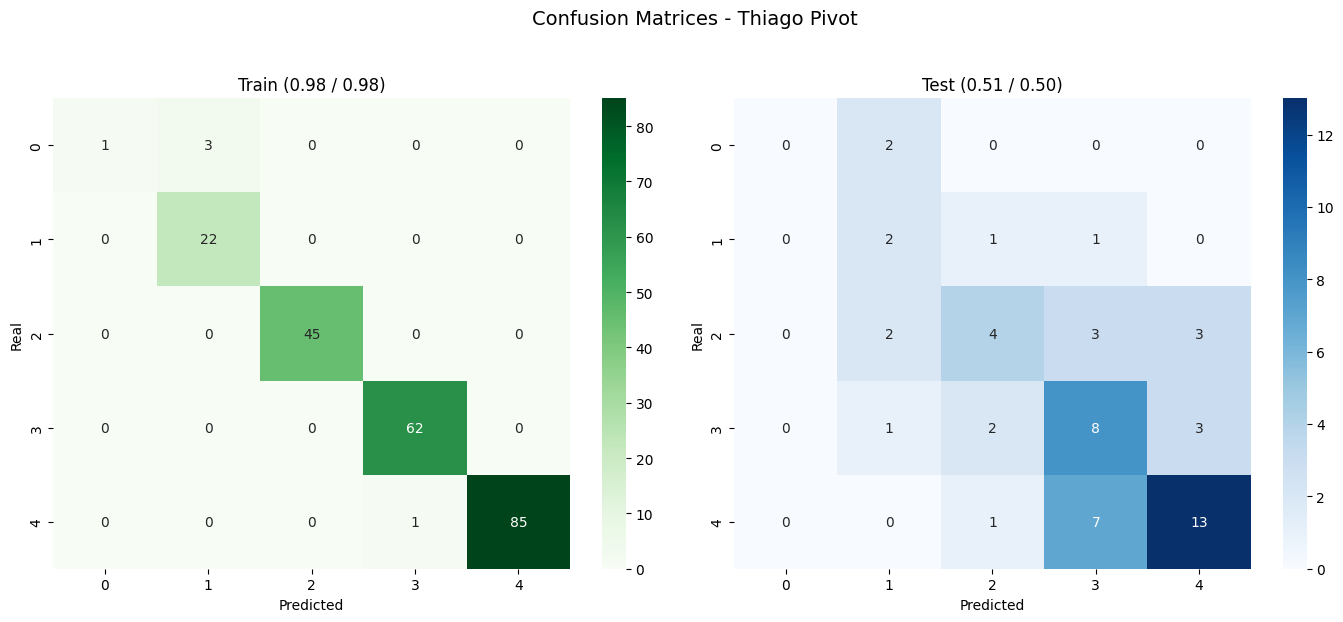

In [63]:
train_file_path = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\task1\features\train\features_thiago_pivot.csv'

lgbm_params = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'multiclass',
    'num_class': 5,
    'verbose': -1
}

test_ids = [
    "ID007","ID012","ID021","ID029","ID037","ID046","ID051","ID053","ID054","ID056",
    "ID063","ID075","ID083","ID090","ID099","ID101","ID105","ID110","ID116","ID122",
    "ID129","ID136","ID138","ID140","ID158","ID160","ID164","ID171","ID176","ID179",
    "ID202","ID209","ID227","ID229","ID233","ID245","ID252","ID253","ID260","ID261",
    "ID263","ID264","ID269","ID270","ID274","ID278","ID284","ID286","ID290","ID302",
    "ID306","ID323","ID329"
]

META_COLUMNS = ['ID', 'Class']

df_train_full = pd.read_csv(train_file_path)

if 'Sex' in df_train_full.columns:
    df_train_full['Sex'] = df_train_full['Sex'].map({'M': 0, 'F': 1})

df_train_full['Class'] = df_train_full['Class'] - 1

df_train_full = df_train_full.dropna(axis=1, how='all')

def try_parse_array(x):
    try:
        val = literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
        if isinstance(val, (list, tuple, np.ndarray)):
            return np.mean(val)
        return val
    except Exception:
        return x

for col in df_train_full.columns:
    if df_train_full[col].astype(str).str.startswith('[').any():
        df_train_full[col] = df_train_full[col].apply(try_parse_array)

df_test = df_train_full[df_train_full['ID'].isin(test_ids)].copy()
df_train = df_train_full[~df_train_full['ID'].isin(test_ids)].copy()

X_full_orig = df_train_full.drop(columns=META_COLUMNS)
X_full_orig = X_full_orig.select_dtypes(include=[np.number])
y_full = df_train_full['Class']

X_train_orig = df_train.drop(columns=META_COLUMNS).select_dtypes(include=[np.number])
y_train = df_train['Class']

X_test_orig = df_test.drop(columns=META_COLUMNS).select_dtypes(include=[np.number])
y_test = df_test['Class']

scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train_orig)
X_test_processed = scaler.transform(X_test_orig)

lgbm = LGBMClassifier(**lgbm_params)
lgbm.fit(X_train_processed, y_train)

y_train_pred = lgbm.predict(X_train_processed)
y_test_pred = lgbm.predict(X_test_processed)

acc_train = accuracy_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred, average='weighted')
acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print(f'\nDataset: Thiago Pivot')
print('-' * 50)
print(f'Tamanho Treino: {len(X_train_orig)} | Tamanho Teste: {len(X_test_orig)}')
print(f'Accuracy - Train: {acc_train:.4f} | Test: {acc_test:.4f}')
print(f'F1-Score - Train: {f1_train:.4f} | Test: {f1_test:.4f}')
print('-' * 50)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
labels = sorted(y_full.unique())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title(f'Train ({acc_train:.2f} / {f1_train:.2f})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Real')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title(f'Test ({acc_test:.2f} / {f1_test:.2f})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Real')

plt.suptitle(f'Confusion Matrices - Thiago Pivot', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

### IDs do Baseline


Dataset: Thiago Pivot
--------------------------------------------------
Tamanho Treino: 219 | Tamanho Teste: 53
Accuracy - Train: 0.9954 | Test: 0.4717
F1-Score - Train: 0.9952 | Test: 0.4638
--------------------------------------------------


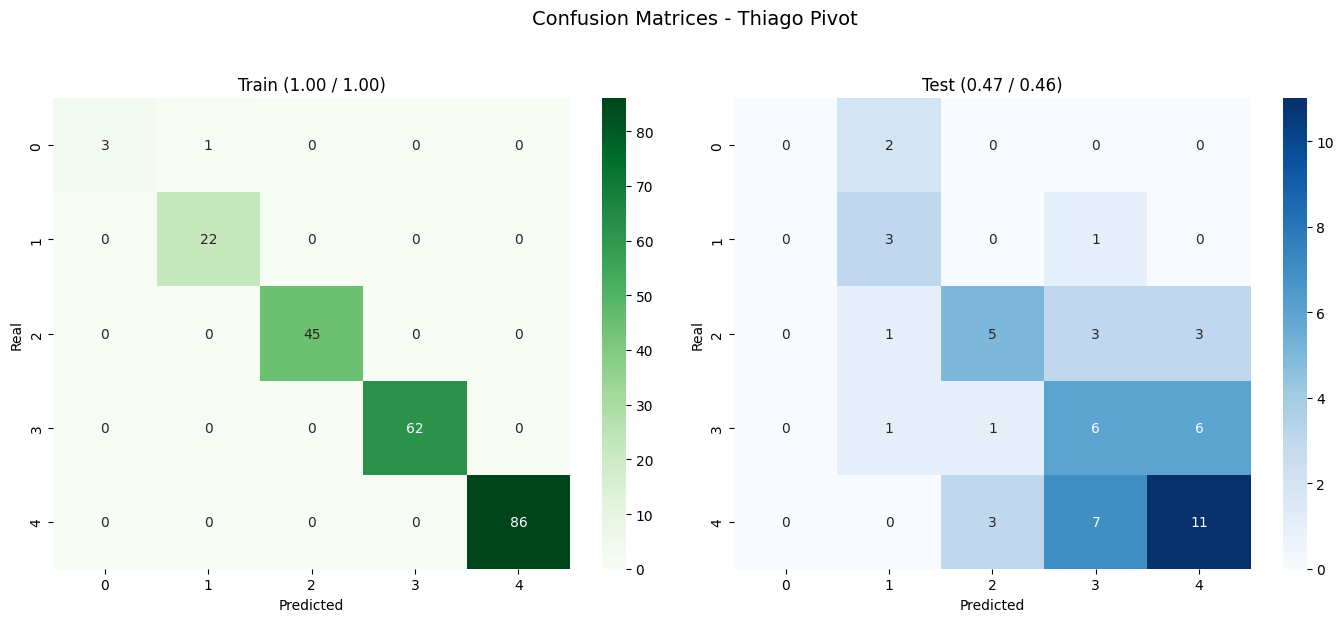

In [13]:
train_file_path = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\task1\features\train\features_filtered.csv'

lgbm_params = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.9,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'multiclass',
    'num_class': 5,
    'verbose': -1
}

test_ids = [
    "ID007","ID012","ID021","ID029","ID037","ID046","ID051","ID053","ID054","ID056",
    "ID063","ID075","ID083","ID090","ID099","ID101","ID105","ID110","ID116","ID122",
    "ID129","ID136","ID138","ID140","ID158","ID160","ID164","ID171","ID176","ID179",
    "ID202","ID209","ID227","ID229","ID233","ID245","ID252","ID253","ID260","ID261",
    "ID263","ID264","ID269","ID270","ID274","ID278","ID284","ID286","ID290","ID302",
    "ID306","ID323","ID329"
]

META_COLUMNS = ['ID', 'Class']

df_train_full = pd.read_csv(train_file_path)

if 'Sex' in df_train_full.columns:
    df_train_full['Sex'] = df_train_full['Sex'].map({'M': 0, 'F': 1})

df_train_full['Class'] = df_train_full['Class'] - 1

df_train_full = df_train_full.dropna(axis=1, how='all')

def try_parse_array(x):
    try:
        val = literal_eval(x) if isinstance(x, str) and x.startswith('[') else x
        if isinstance(val, (list, tuple, np.ndarray)):
            return np.mean(val)
        return val
    except Exception:
        return x

for col in df_train_full.columns:
    if df_train_full[col].astype(str).str.startswith('[').any():
        df_train_full[col] = df_train_full[col].apply(try_parse_array)

df_test = df_train_full[df_train_full['ID'].isin(test_ids)].copy()
df_train = df_train_full[~df_train_full['ID'].isin(test_ids)].copy()

X_full_orig = df_train_full.drop(columns=META_COLUMNS)
X_full_orig = X_full_orig.select_dtypes(include=[np.number])
y_full = df_train_full['Class']

X_train_orig = df_train.drop(columns=META_COLUMNS).select_dtypes(include=[np.number])
y_train = df_train['Class']

X_test_orig = df_test.drop(columns=META_COLUMNS).select_dtypes(include=[np.number])
y_test = df_test['Class']

scaler = StandardScaler()
X_train_processed = scaler.fit_transform(X_train_orig)
X_test_processed = scaler.transform(X_test_orig)

lgbm = LGBMClassifier(**lgbm_params)
lgbm.fit(X_train_processed, y_train)

y_train_pred = lgbm.predict(X_train_processed)
y_test_pred = lgbm.predict(X_test_processed)

acc_train = accuracy_score(y_train, y_train_pred)
f1_train = f1_score(y_train, y_train_pred, average='weighted')
acc_test = accuracy_score(y_test, y_test_pred)
f1_test = f1_score(y_test, y_test_pred, average='weighted')

print(f'\nDataset: Thiago Pivot')
print('-' * 50)
print(f'Tamanho Treino: {len(X_train_orig)} | Tamanho Teste: {len(X_test_orig)}')
print(f'Accuracy - Train: {acc_train:.4f} | Test: {acc_test:.4f}')
print(f'F1-Score - Train: {f1_train:.4f} | Test: {f1_test:.4f}')
print('-' * 50)

cm_train = confusion_matrix(y_train, y_train_pred)
cm_test = confusion_matrix(y_test, y_test_pred)
labels = sorted(y_full.unique())

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
            xticklabels=labels, yticklabels=labels, ax=axes[0])
axes[0].set_title(f'Train ({acc_train:.2f} / {f1_train:.2f})')
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Real')

sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels, ax=axes[1])
axes[1].set_title(f'Test ({acc_test:.2f} / {f1_test:.2f})')
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Real')

plt.suptitle(f'Confusion Matrices - Thiago Pivot', fontsize=14, y=1.03)
plt.tight_layout()
plt.show()

### V2 - PÓS ANÁLISE DO THIAGO

In [12]:
import pandas as pd
from collections import OrderedDict

df = pd.read_csv(r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\task1\features\train\features_thiago_pivot.csv')

target_prefixes = [
    'ID',
    'Class',
    'Age',
    'Sex',
    'num_voiced_segments',
    'tremor',
    'voice_breaks',
    'articulation_sharpness',
    'frequency',
    'mean_counts',
    'median_counts',
    'peaks_per_sec',
    'mean_ratio_low',
    'mean_ratio_mid',
    'std_ratio_low',
    'std_ratio_mid',
    'mean_ratio_fundamental',
    'std_spread',
    'cv_spread',
    'mean_concentration',
    'std_concentration',
    'mean_spectral_slope',
    'std_spectral_slope',
    'std_spectral_entropy',
    'power_max_db',
    'std_power_diff_db',
]

groups = OrderedDict()
for p in target_prefixes:
    matches = [c for c in df.columns if c == p or c.startswith(p + '_')]
    groups[p] = matches

for p, cols in groups.items():
    print(f"{p}: {len(cols)} colunas")
    print("  ", cols)

selected_cols = [c for cols in groups.values() for c in cols]
selected_cols = list(dict.fromkeys(selected_cols))

df_pivot = df[selected_cols].copy()

output_path = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\task1\features\train\features_filtered.csv'
df_pivot.to_csv(output_path, index=False)

print(f"\nTotal colunas selecionadas: {len(selected_cols)}")
print(f"Arquivo salvo em: {output_path}")


ID: 1 colunas
   ['ID']
Class: 1 colunas
   ['Class']
Age: 1 colunas
   ['Age']
Sex: 1 colunas
   ['Sex']
num_voiced_segments: 5 colunas
   ['num_voiced_segments_phonationA', 'num_voiced_segments_phonationE', 'num_voiced_segments_phonationI', 'num_voiced_segments_phonationO', 'num_voiced_segments_phonationU']
tremor: 5 colunas
   ['tremor_phonationA', 'tremor_phonationE', 'tremor_phonationI', 'tremor_phonationO', 'tremor_phonationU']
voice_breaks: 5 colunas
   ['voice_breaks_phonationA', 'voice_breaks_phonationE', 'voice_breaks_phonationI', 'voice_breaks_phonationO', 'voice_breaks_phonationU']
articulation_sharpness: 3 colunas
   ['articulation_sharpness_rhythmKA', 'articulation_sharpness_rhythmPA', 'articulation_sharpness_rhythmTA']
frequency: 3 colunas
   ['frequency_rhythmKA', 'frequency_rhythmPA', 'frequency_rhythmTA']
mean_counts: 3 colunas
   ['mean_counts_rhythmKA', 'mean_counts_rhythmPA', 'mean_counts_rhythmTA']
median_counts: 3 colunas
   ['median_counts_rhythmKA', 'median_cou

In [ ]:
import pandas as pd
import numpy as np
import ast
import re

file_path = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\task1\features\train\features_thiago.csv'

df = pd.read_csv(file_path)

def is_list_like(x):
    if isinstance(x, (list, np.ndarray)):
        return True
    if isinstance(x, str) and x.strip().startswith('[') and x.strip().endswith(']'):
        return True
    return False

cols_with_arrays = [col for col in df.columns if df[col].apply(is_list_like).any()]
df_arrays = df[cols_with_arrays].copy()

print(f"✅ Colunas detectadas com arrays/listas: {cols_with_arrays}")

# --- conversão segura ---
def safe_to_list(x):
    if not isinstance(x, str):
        return x
    s = x.strip()
    if not (s.startswith('[') and s.endswith(']')):
        return x
    try:
        # tenta interpretar como lista Python
        return ast.literal_eval(s)
    except Exception:
        # tenta corrigir arrays tipo "[1. 2. 3.]" -> "[1., 2., 3.]"
        fixed = re.sub(r'\s+', ', ', s.strip())
        try:
            return ast.literal_eval(fixed)
        except Exception:
            # se ainda falhar, devolve string original
            return s

# aplica conversão a todas as colunas detectadas
for col in df_arrays.columns:
    df_arrays[col] = df_arrays[col].apply(safe_to_list)

# salva o novo CSV
output_path = r'C:\Users\joaov_zm1q2wh\python\icassp_challenge\data\task1\features\train\features_arrays_only.csv'
df_arrays.to_csv(output_path, index=False)

print(f"💾 Novo CSV salvo em: {output_path}")


========== Dataset: Original ==========
Train: 219 | Test : 53
Aplicando StandardScaler nas features 'Original'...
Iniciando GridSearchCV...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11977
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 162
[LightGBM] [Info] Start training from score -4.002777
[LightGBM] [Info] Start training from score -2.298029
[LightGBM] [Info] Start training from score -1.582409
[LightGBM] [Info] Start training from score -1.261937
[LightGBM] [Info] Start training from score -0.934724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

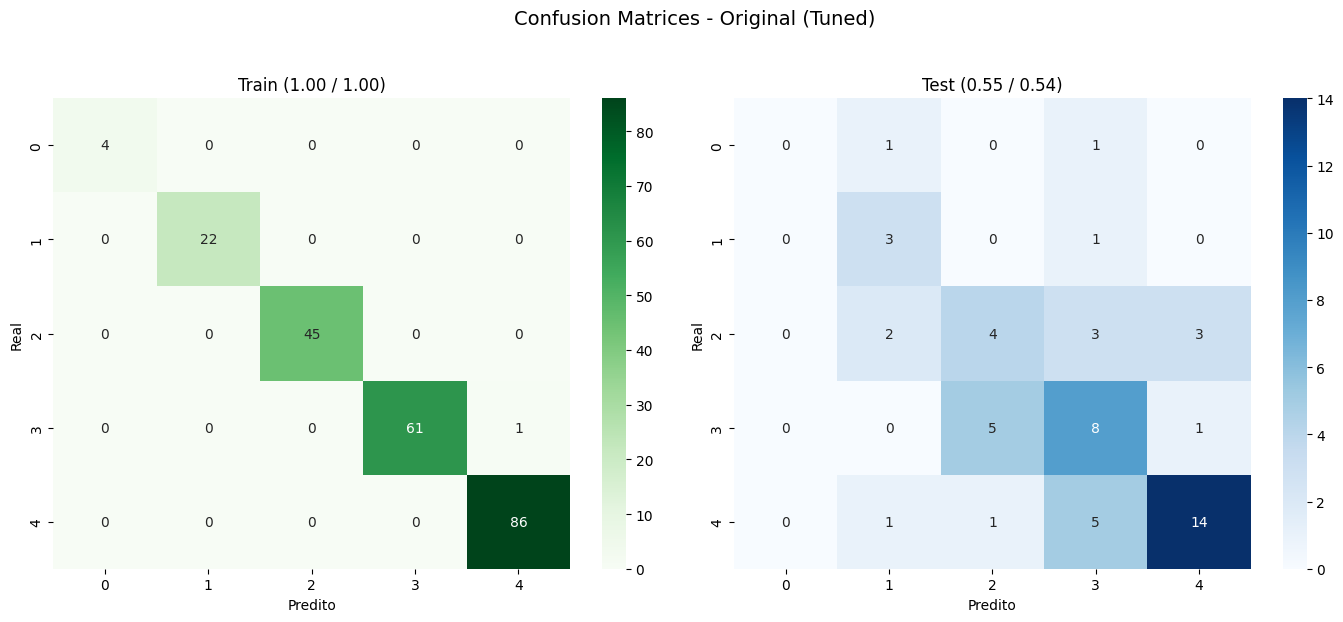


========== Dataset: Z-Score ==========
Train: 219 | Test : 53
Iniciando GridSearchCV...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000969 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11976
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 162
[LightGBM] [Info] Start training from score -4.002777
[LightGBM] [Info] Start training from score -2.298029
[LightGBM] [Info] Start training from score -1.582409
[LightGBM] [Info] Start training from score -1.261937
[LightGBM] [Info] Start training from score -0.934724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

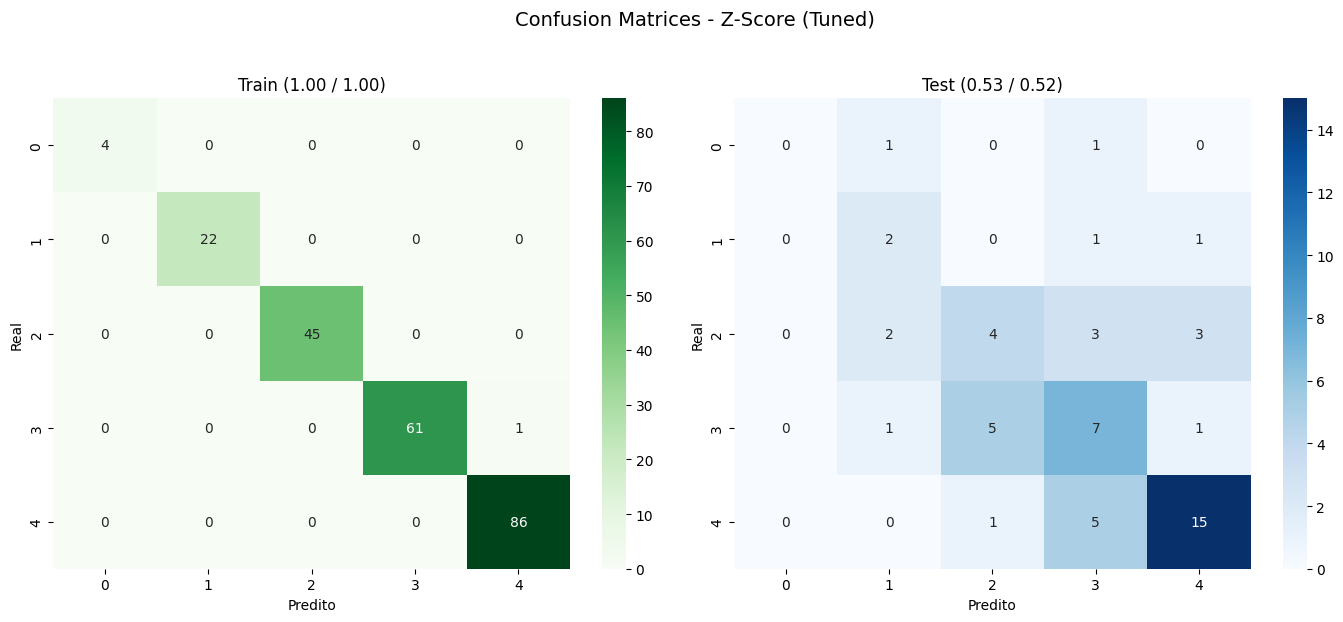


========== Dataset: Min-Max ==========
Train: 219 | Test : 53
Iniciando GridSearchCV...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11883
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 162
[LightGBM] [Info] Start training from score -4.002777
[LightGBM] [Info] Start training from score -2.298029
[LightGBM] [Info] Start training from score -1.582409
[LightGBM] [Info] Start training from score -1.261937
[LightGBM] [Info] Start training from score -0.934724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

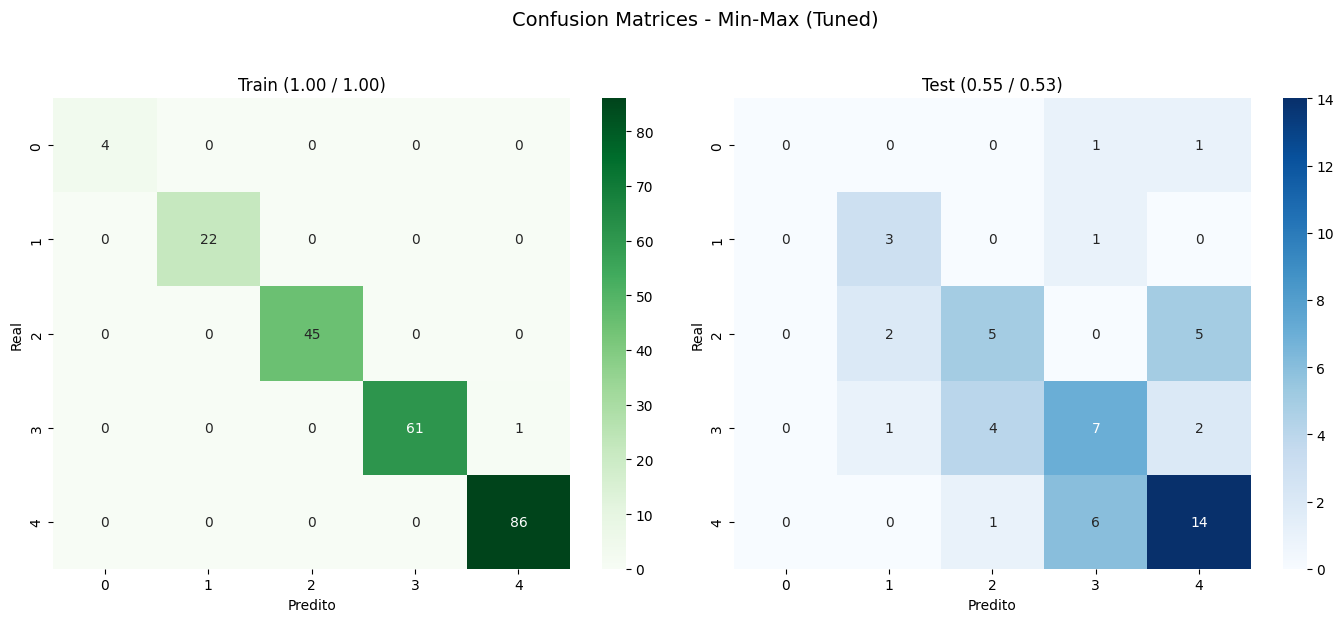


========== Dataset: SN Min-Max ==========
Train: 219 | Test : 53
Iniciando GridSearchCV...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11883
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 162
[LightGBM] [Info] Start training from score -4.002777
[LightGBM] [Info] Start training from score -2.298029
[LightGBM] [Info] Start training from score -1.582409
[LightGBM] [Info] Start training from score -1.261937
[LightGBM] [Info] Start training from score -0.934724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

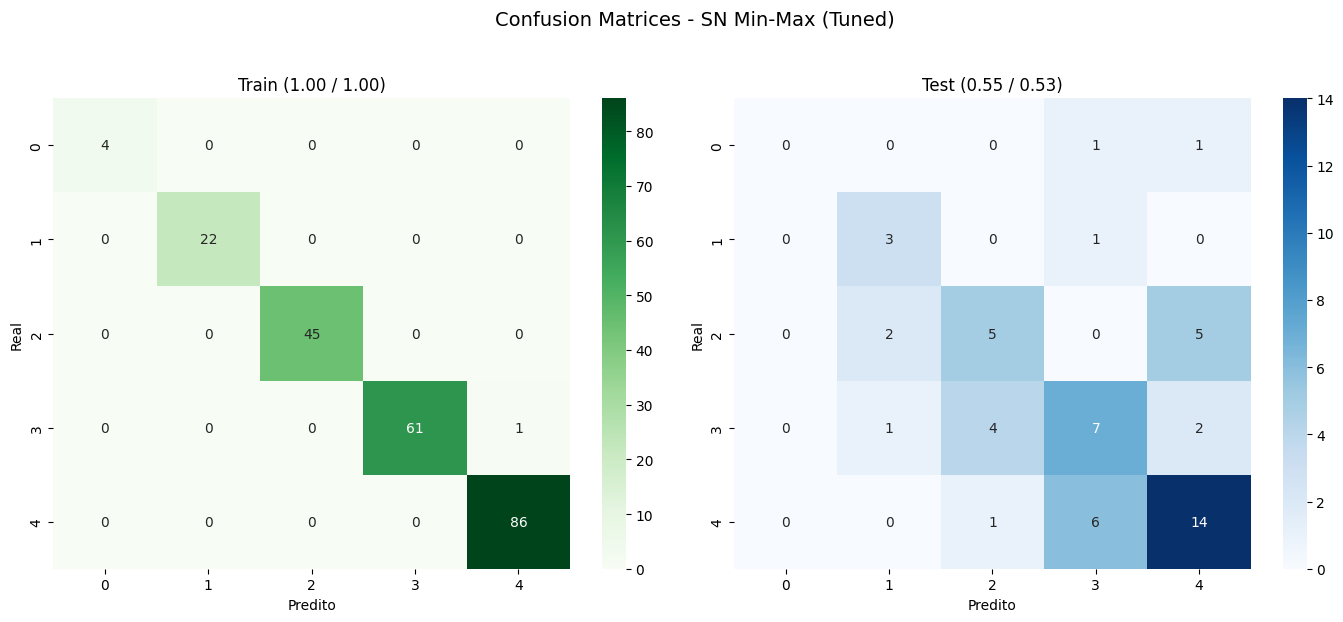


========== Dataset: SN Z-Score ==========
Train: 219 | Test : 53
Iniciando GridSearchCV...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 11976
[LightGBM] [Info] Number of data points in the train set: 219, number of used features: 162
[LightGBM] [Info] Start training from score -4.002777
[LightGBM] [Info] Start training from score -2.298029
[LightGBM] [Info] Start training from score -1.582409
[LightGBM] [Info] Start training from score -1.261937
[LightGBM] [Info] Start training from score -0.934724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best

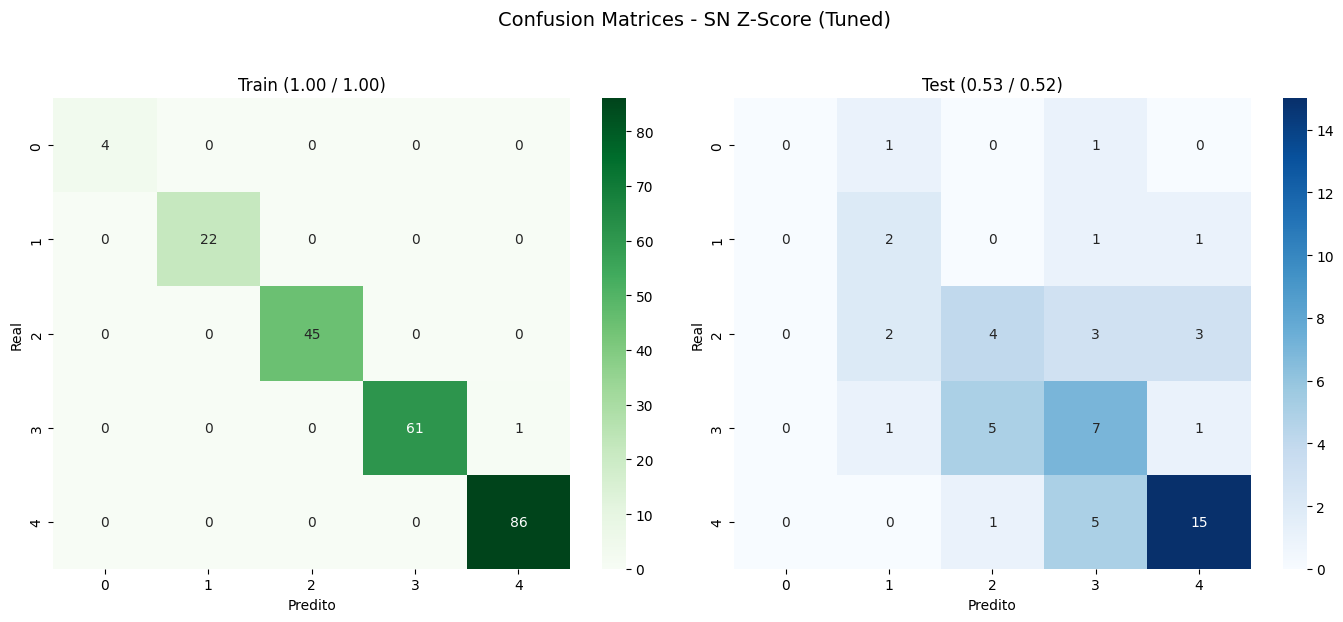


=== Resumo dos Resultados com Hyperparameter Tuning ===
      Dataset  Accuracy  F1-Score  \
0    Original  0.547170  0.540045   
1     Z-Score  0.528302  0.521737   
2     Min-Max  0.547170  0.533728   
3  SN Min-Max  0.547170  0.533728   
4  SN Z-Score  0.528302  0.521737   

                                         Best Params  
0  {'colsample_bytree': 0.9, 'learning_rate': 0.0...  
1  {'colsample_bytree': 0.9, 'learning_rate': 0.0...  
2  {'colsample_bytree': 0.7, 'learning_rate': 0.0...  
3  {'colsample_bytree': 0.7, 'learning_rate': 0.0...  
4  {'colsample_bytree': 0.9, 'learning_rate': 0.0...  


In [2]:
train_file_paths = {
    'Original': r'..\data\task1\features\train\features_raw.csv',
    'Z-Score': r'..\data\task1\features\train\features_z_score.csv',
    'Min-Max': r'..\data\task1\features\train\features_min_max_0_1.csv',
    'SN Min-Max': r'..\data\task1\features\train\features_signal_norm_-1_1_min_max_0_1.csv',
    'SN Z-Score': r'..\data\task1\features\train\features_signal_norm_-1_1_z_score.csv',
}

lgbm_base_params = {
    'n_estimators': 300,
    'random_state': 42,
    'n_jobs': -1,
    'objective': 'multiclass',
    'num_class': 5
}

test_ids = [
    "ID007","ID012","ID021","ID029","ID037","ID046","ID051","ID053","ID054","ID056",
    "ID063","ID075","ID083","ID090","ID099","ID101","ID105","ID110","ID116","ID122",
    "ID129","ID136","ID138","ID140","ID158","ID160","ID164","ID171","ID176","ID179",
    "ID202","ID209","ID227","ID229","ID233","ID245","ID252","ID253","ID260","ID261",
    "ID263","ID264","ID269","ID270","ID274","ID278","ID284","ID286","ID290","ID302",
    "ID306","ID323","ID329"
]

META_COLUMNS = ['ID', 'Class']
results = []

param_grid = {
    'max_depth': [6, 8, 10],  # Profundidade máxima da árvore
    'learning_rate': [0.01, 0.05, 0.1],  # Taxa de aprendizado
    'colsample_bytree': [0.7, 0.9],  # Subamostragem de colunas
    # 'n_estimators': [200, 300] # Opcional: variar n_estimators
}


for name, train_path in train_file_paths.items():
    print(f'\n{"="*10} Dataset: {name} {"="*10}')
    
    try:
        df_train_full = pd.read_csv(train_path)
    except FileNotFoundError as e:
        print(f'Erro: {e}')
        continue

    # Pré-processamento de 'Sex' e 'Class'
    if 'Sex' in df_train_full.columns:
        df_train_full['Sex'] = df_train_full['Sex'].map({'M': 0, 'F': 1})

    df_train_full['Class'] = df_train_full['Class'] - 1

    # Divisão em Treinamento e Teste
    df_test = df_train_full[df_train_full['ID'].isin(test_ids)].copy()
    df_train = df_train_full[~df_train_full['ID'].isin(test_ids)].copy()

    X_train = df_train.drop(columns=META_COLUMNS)
    y_train = df_train['Class']
    
    X_test = df_test.drop(columns=META_COLUMNS)
    y_test = df_test['Class']
    
    print(f'Train: {len(X_train)} | Test : {len(X_test)}')

    # Padronização/Normalização para 'Original'
    if 'Original' in name:
        print("Aplicando StandardScaler nas features 'Original'...")
        scaler = StandardScaler()
        X_train_processed = scaler.fit_transform(X_train)
        X_test_processed = scaler.transform(X_test)
    else:
        # Para datasets pré-processados, usar apenas os valores
        X_train_processed = X_train.values
        X_test_processed = X_test.values

    # 1. Configuração do Modelo e Busca de Hiperparâmetros
    lgbm_model = LGBMClassifier(**lgbm_base_params)

    print("Iniciando GridSearchCV...")
    grid_search = GridSearchCV(
        estimator=lgbm_model,
        param_grid=param_grid,
        scoring='f1_weighted', # Métrica a ser otimizada (F1-score ponderado)
        cv=5, # Validação cruzada com 5 folds
        verbose=1,
        n_jobs=-1
    )

    # Executa a busca (treina o modelo com diferentes combinações)
    grid_search.fit(X_train_processed, y_train)

    # 2. Utiliza o Melhor Estimador Encontrado
    lgbm_best = grid_search.best_estimator_

    print(f"Melhores parâmetros encontrados: {grid_search.best_params_}")
    print(f"Melhor F1-Score (Treino CV): {grid_search.best_score_:.4f}")
    
    # Treinamento final (já feito internamente pelo GridSearchCV, mas aqui usamos o melhor)
    # lgbm_best.fit(X_train_processed, y_train) # Não é necessário se usarmos o best_estimator_ diretamente

    # 3. Predições e Avaliação
    y_train_pred = lgbm_best.predict(X_train_processed)
    y_test_pred = lgbm_best.predict(X_test_processed)

    acc_train = accuracy_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred, average='weighted')
    acc_test = accuracy_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred, average='weighted')

    print('-' * 50)
    print(f'Métricas Finais (Melhores Hiperparâmetros):')
    print(f'Accuracy - Train: {acc_train:.4f} | Test: {acc_test:.4f}')
    print(f'F1-Score - Train: {f1_train:.4f} | Test: {f1_test:.4f}')
    print('-' * 50)

    results.append({
        'Dataset': name,
        'Accuracy': acc_test,
        'F1-Score': f1_test,
        'Best Params': grid_search.best_params_ # Adiciona os melhores parâmetros
    })

    # Plotagem da Matriz de Confusão (mantido)
    cm_train = confusion_matrix(y_train, y_train_pred)
    cm_test = confusion_matrix(y_test, y_test_pred)
    labels = sorted(df_train_full['Class'].unique())

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    sns.heatmap(cm_train, annot=True, fmt='d', cmap='Greens',
                xticklabels=labels, yticklabels=labels, ax=axes[0])
    axes[0].set_title(f'Train ({acc_train:.2f} / {f1_train:.2f})')
    axes[0].set_xlabel('Predito')
    axes[0].set_ylabel('Real')

    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels, ax=axes[1])
    axes[1].set_title(f'Test ({acc_test:.2f} / {f1_test:.2f})')
    axes[1].set_xlabel('Predito')
    axes[1].set_ylabel('Real')

    plt.suptitle(f'Confusion Matrices - {name} (Tuned)', fontsize=14, y=1.03)
    plt.tight_layout()
    plt.show()
    
# Exibe os resultados finais
print("\n=== Resumo dos Resultados com Hyperparameter Tuning ===")
df_results = pd.DataFrame(results)
print(df_results)